<img src="./figs/Logos.png" alt="drawing"/>

# Clay Conference 2024 - Scientific Support Programme: From Equations to Simulations: An interactive introduction to a numerical fluid flow implementation

by M. Pitz and Th. Nagel

In [40]:
# Some extra useful libraries that need to be
# imported first so that python can perform 
# the desired numerical computations (numpy)
# as well as produce some nice figures (matplotlib)

import numpy as np
import matplotlib.pyplot as plt

## Introduction

### Finite Volumes, finite differences and finite elements as common numerical methods

Numerical methods play a crucial role in solving partial differential equations (PDEs) that arise in various fields such as fluid dynamics or heat transfer, and mechanics. Among these methods, the finite volume method (FVM) stands out for its ability to conserve physical quantities, such as mass, momentum, and energy, locally on a discretized domain. The FVM works by dividing the domain into a finite number of control volumes and applying the integral form of the conservation laws. This approach ensures that fluxes entering and leaving each control volume are accurately accounted for, making FVM particularly well-suited for problems involving conservation laws and complex geometries.

The finite volume method resembles but also differs from other numerical methods such as, finite differences (FDM), and finite elements (FEM) with respect to different aspects. All three methods discretize the continuous domain to solve PDEs numerically. They can be used to approximate solutions to steady-state and time-dependent problems.

Some differences between the methods are

* Finite Volume Method: Focuses on conservation laws and integrates over control volumes. It conserves fluxes across boundaries, making it ideal for fluid dynamics.

* Finite Difference Method: Approximates derivatives using differences between function values at discrete grid points. It's straightforward and efficient but can struggle with complex geometries and boundary conditions.

* Finite Element Method: Divides the domain into elements and uses variational principles or Galerkin methods to formulate the problem. It is highly flexible for complex geometries and provides good convergence properties, especially for higher-order PDEs.

In the following script, we will focus on the finite volume method and we will consider a steady-state problem in fluid flow though a continuous porous medium.

For a comprehensive, interactive set of jupyter notebooks treating numerical methods in engineering, check out https://nagelt.github.io/Numerical_Methods_Introduction/

### The steady state condition
In the steady state, the considered system does not evolve over time, i.e. all variables are constant with regard to time. They can of course vary with regard to space, e.g. there can be a liquid pressure gradient driving a liquid flow. 

For this condition to be true at every point in our system, the inflow of mass must equal the outflow of mass at each point under consideration (If they are not equal, there must be a mass source or sink at this location. We will consider mass sources and sinks later but for now we leave them aside).

## Some basic definitions
### Darcy flow (mass flow per unit area)

The flow of water is expressed using the Darcy flow modified by considering the liquid relative permeability in unsaturated porous media:

\begin{equation}
\mathbf{A} = - \rho(p) \underbrace{\frac{k_\mathrm{int}{k}_\mathrm{rel}(p)}{\mu}}_{\begin{matrix} =\, k_\mathrm{eff}(p)\\\mathrm{(hydraulic} \\ \mathrm{conductivity)}\end{matrix}} \,\mathrm{grad} \, p \, ,
\end{equation}

where we have neglected body forces due to gravity.

Hence, the mass balance equation reads (note that one could multiply all sides of the equation by (-1), thus getting rid of the negative sign. We won't do this here, because later on we will add more terms to this equation and the sign will matter then):

\begin{equation}
     0= \mathrm{div} \, \bigl( - \rho(p) k_\mathrm{eff}(p) \,  \mathrm{grad} \, p \bigr)
\end{equation}

The hydraulic conductivity depends on the intrinsic permeability of the porous medium, the liquid viscosity as well as on the liquid density and the relative permeability (in unsaturated media). While we consider the former two parameters to be constants, we assume the latter two paramters to be functions of the liquid pressure and liquid saturation, respectively. In order to make life easier, python lets us define functions that can later be called like this:

In [41]:
# define a function calculating the effective permeability
def rho_times_k_eff(p):
    mu = 5.0e-4 # liquid viscosity / Pa s
    k_int = 1.0e-18 # intrinsic permeability / m^2
    return - rho(p) * k_rel(p) * k_int / mu

Note that in the code snipped above, ```rho(p)``` and ```k_rel(p)``` are not constants but themselves functions that are called and that take a variable $p$ as input. Note here that although we said that the relative permeability depends on the liquid saturation $S$, we let it take the liquid pressure $p$ as input instead. This is because we choose $p$ to be our primary variable and therefore, we want to express every variable as a function of $p$ (making some simplifying assumptions along the way).

Let's proceed to define the relative permeability of the liquid phase to be saturation-dependent, according to van Genuchten/Mualem with

\begin{equation}
    k_\mathrm{rel} = \sqrt{S} \left(1-\left( 1-S^{\frac{n}{n-1}}\right)\right)^{\frac{2n-n}{n}}
\end{equation}

One can see that $k_\mathrm{rel}$ depends on the liquid saturation $S$ with is in turn a function of the liquid pressure. Let us define it using the formulation by van Genuchten: 

\begin{equation}
        S =
        \begin{cases}
        \, \left( 1+\left(\frac{-p}{p_\mathrm{entry}}\right)^n \right)^{\frac{1}{n}-1} \, \, &\text{if} \, \, p < 0 \\
        \, 1 \, \, &\text{else} \\
        \end{cases}
\end{equation}

In [42]:
# properties defining the relative liquid 
# permeability and degree of liquid saturation,
# defined as functions of the liquid pressure,
# both according to van Genuchten (1980) and Mualem (19XX)

n = 1.49 # van Genuchten n
pe = 2.0e06 # van Genuchten entry pressure

# define function calculating the relative permeability 
# of liquid as a function of of liquid pressure
def k_rel(p):
    m = 1-1/n
    return np.sqrt(S(p)) * np.power(1-(np.power(1-np.power(S(p),1/m),m)),2)

# define a function calculating the degree of liquid
# saturation as a function of liquid pressure
def S(p):
    if p < 0.0:
        return np.power(1+np.power(-p/pe,n),(1/n)-1)
    else:
        return 1.0

In the next bit of code, we draw some some plots illustrating 
* (a) the degree of liquid saturation $S$ as a function of the liquid pressure $p$ ,
* (b) the relative permeability as a function of pressure $p$ and
* (c) the relative permeability as a function of saturation $S$.

All plots consider a liquid pressure range between $-3 \, \mathrm{MPa}$ and $1\, \mathrm{MPa}$ which is about the pressure range used for the numerical examples in this script. Here, we use the relation of pressure and saturation (retention curve) proposed by van Genuchten (1984) as well as the relative permeability relation by Mualem (19XX).  We see in plot (a) that the liquid saturation is equal to 1 for positive pressures. For negative pressures, it takes values between 0 and 1. $S$ approaches zero when $p$ approaches negative infinity. This implies that the liquid can never be fully drained from the porous medium. Using negative liquid pressures to describe unsaturated conditions is an approach widely used in modelling and based on the work by Richards (1930). The liquid relative permeability is constant and equal to one for positive pressure (fully saturated conditions). The relative permeability decreases fast with decreasing liquid saturation $S$, because the wetting liquid phase adheres to the grains, thus reducing the crosssectional area available to the liquid flow (phase connectedness).

<IPython.core.display.Javascript object>


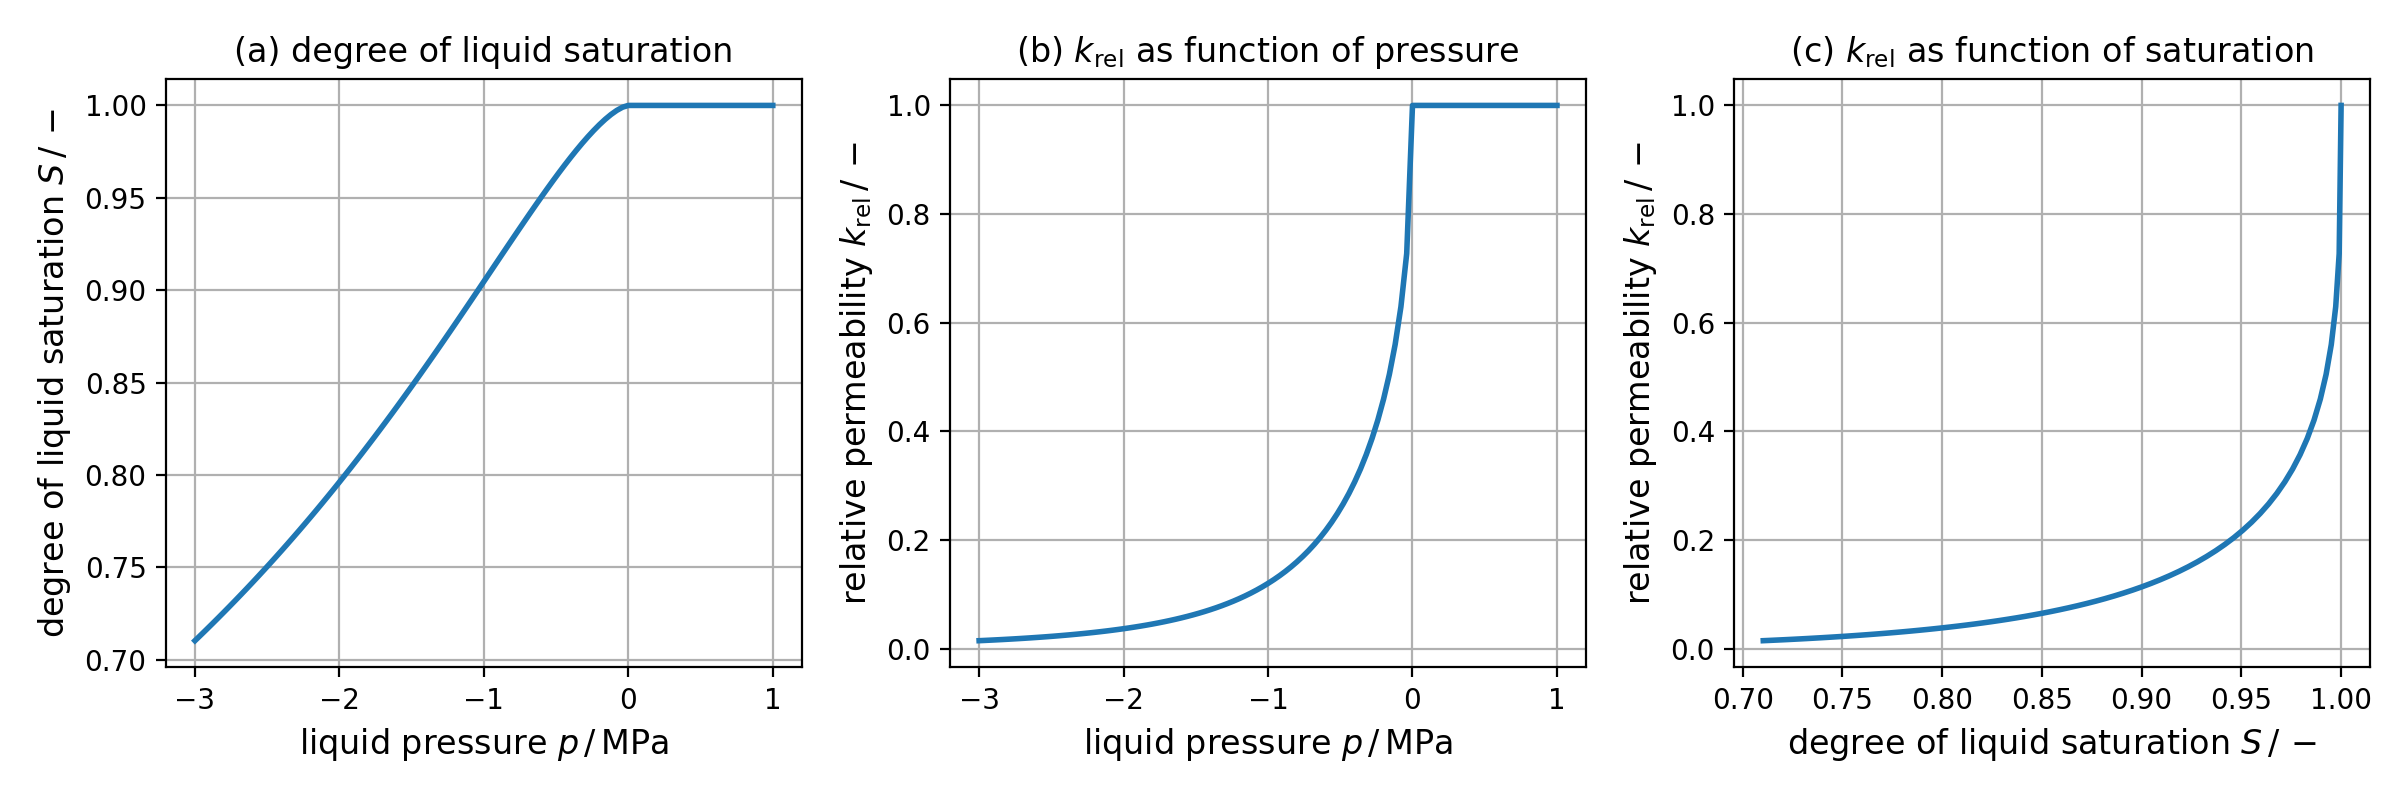

In [43]:
pressure = np.linspace(-3e6,1e6, 101) # define a liquid pressure range
saturation = [S(p) for p in pressure] # calculate corresp. saturations
rel_permeability = [k_rel(p) for p in pressure] # calculate corresp. relperms

# some plot settings
width = 2 # line width
fsize = 12 # font size

# plot saturation
fig1 = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(pressure/1e6, saturation, linewidth = width) # plot
plt.grid()
plt.xlabel("liquid pressure $p \, / \, \\mathrm{MPa}$", fontsize = fsize)
plt.ylabel("degree of liquid saturation $S \, / \, -$", fontsize = fsize)
plt.title("(a) degree of liquid saturation", fontsize = fsize)

# plot relative permeability as function of liquid pressure
plt.subplot(1,3,2)
plt.plot(pressure/1e6, rel_permeability, linewidth = width) # plot
plt.xlabel("liquid pressure $p \, / \, \\mathrm{MPa}$", fontsize = fsize)
plt.ylabel("relative permeability $k_\\mathrm{rel} \, / \, -$", fontsize = fsize)
plt.title("(b) $k_\\mathrm{rel}$ as function of pressure", fontsize = fsize)
plt.grid()

# plot relative permeability as function of liquid saturation
plt.subplot(1,3,3)
plt.plot(saturation, rel_permeability, linewidth = width) # plot
plt.xlabel( "degree of liquid saturation $S \, / \, -$", fontsize = fsize)
plt.ylabel("relative permeability $k_\\mathrm{rel} \, / \, -$", fontsize = fsize)
plt.title("(c) $k_\\mathrm{rel}$ as function of saturation", fontsize = fsize)
plt.grid()

fig1.tight_layout()

Lastly, in this script, the liquid density is modelled as a function of the liquid pressure. We do not need to consider temperature dependency because we assume isothermal conditions. Here, we use a linear dependency with

\begin{equation}
        \rho = \rho^\mathrm{ref} \left( 1+\beta_{p}\left(p-p^\mathrm{ref}\right) \right)\, , 
\end{equation}

Let us define this function and plot it:

<IPython.core.display.Javascript object>


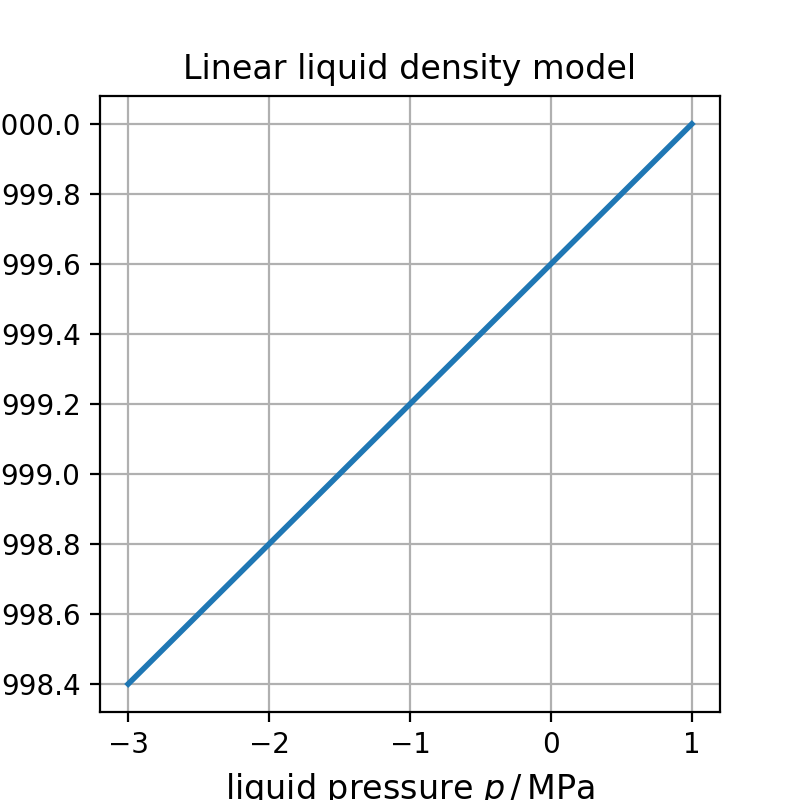

Text(0.5, 1.0, 'Linear liquid density model')

In [44]:
def rho(p):
    p_ref = 1.0e06   # reference liquid pressure / Pa
    beta_p = 4.0e-10 # liquid compressibility / Pa^-1
    rho_ref = 1000.0 # reference liquid density / kg m^-3
    return rho_ref * (1+beta_p*(p-p_ref))

density = [rho(p) for p in pressure] # calculate corresp. relperms

fig2 = plt.figure(figsize=(4,4))
plt.plot(pressure/1e6, density, linewidth = width) # plot
plt.grid()
plt.xlabel("liquid pressure $p \, / \, \\mathrm{MPa}$", fontsize = fsize)
plt.ylabel("liquid density $\\rho \, / \, \mathrm{kg} \, \\mathrm{m}^{-3}$", fontsize = fsize)
plt.title("Linear liquid density model", fontsize = fsize)

## Solving a partial differential liquid flow equation using the finite volume method
### The divergence of the mass flow vector field
In the mass balance equations, we express this balance of in- and outflow at a given point using the divergence operator $\mathrm{div}$, which we will now explore. Sometimes, the symbols $\nabla \cdot$ are used to denote the divergence with the same meaning. Let us call the liquid mass flow $\mathbf{A}$. It is a vector with three components in 3D, two components in 2D and one component in 1D (our case), which points into the direction of the fluid flow and whose length corresponds to the amount of mass that is flowing. We have defined $\mathbf{A}$ further below. Then, the steady state condition reads in the absence of sinks and sources:

\begin{equation}
    0 = \mathrm{div} \, \left(\mathbf{A}\right)
\end{equation}

An intuition is given by the figure below: There is a (positive) divergence of the mass flow, if less mass flows into the considered point than out. In the opposite case, the divergence is negative. If the same amount of mass flows in as out, the divergence equals zero (which is the condition we are looking for when finding the source-free steady state solution):

<img src="./figs/Divergence.png" alt="drawing" width="500"/>

<center>Figure 1: Divergence of a vector field</center>

In the special 1D case, $\mathbf{A}$ must actually be constant across the entire domain for $\mathrm{div} \, \left(\mathbf{A}\right)$ to equal zero. In 2D, this is not necessarily the case because of geometrical effects.

(Note: Mathematically, the divergence is simply the change of the mass flow with respect to the $x$-direction for one dimension (like in our case):

\begin{equation}
\mathrm{div} \, \left(\mathbf{A}\right) = \frac{\partial \mathbf{A}}{\partial x}
\end{equation}

For completeness, we note that in three dimensions, the divergence of the mass flow vector field would be calculated as the sum of the partial derivatives with respect to each coordinate, i.e. $ \mathrm{div} \, \left(\mathbf{A}\right) = \frac{\partial \mathbf{A}}{\partial x} + \frac{\partial \mathbf{A}}{\partial y} + \frac{\partial \mathbf{A}}{\partial z}$. In other words, the divergence is the trace of the gradient. In this script however, instead of calculating the derivatives of the mass flow directly, we approximate the divergence operator as shown below, using the finite volume method.)

## Approximating the divergence operator using finite volumes:

In the finite volume method, the continuous domain is divided into a finite number of $N+1$ volumes with indices ranging from 1 to $N$, individually denoted as $V_0$ to $V_N$. Thus, instead of keeping track of the continous liquid pressure profile, we only keep track of a representative cell-centred pressure $p_n$ which we assume to be present in the entire Volume $V_n$.

Using this finite amount of volumes, the divergence around each individual volume is actually interpreted straight via its physical meaning, i.e. as the balance of in- and outflow into the respective volume/cell. Consider the figure below: Calculating the balance in this case for the nth volume $V_n$ means that we can calculate the mass flow balance directly as the difference between the mass flow from the "left" volume $V_{n-1}$ into the nth volume $V_n$ and the mass flow from the volume $V_{n}$ into the "right" volume $V_{n+1}$

<img src="./figs/Finite_Volumes.png" alt="drawing" width="800"/>

<center>Figure 2: Discretizing the continuous domain into a finite number of (cubic) volumes let's us approximate the liquid pressure gradient between neighbouring cells as well as the mass flow divergence around each cell.</center>

Above, we have definded the mass flow according to Darcy $\mathbf{A}$ as the mass that flows across a plane with the unit area. If we apply the point-wise equation $\mathrm{div} \, \mathbf{A} = 0$ to a 1D domain with potentially variable cross-section, we balance total in and out-flowrates. Therefore, $\mathbf{A}$ has to be multiplied with the surface area of the interface of each two considered volumes. In our case, we choose the surface area to be $1\, \mathrm{m}^2$ for simplicity (one can see below that because of the 1D nature of this example, we have $I^\mathrm{left} = I^\mathrm{right} \neq 0$, so one could devide by this area straight away and get rid of it). As stated above, we then calculate discretized divergence around the volume $V_n$ (indicated below as $\mathrm{div}_n$) as the difference of mass flow on the left and right sides of the volume:

\begin{equation}
    \mathrm{div}_n \, \left(\mathbf{A}\right) = \mathbf{A}_n^\mathrm{right}\cdot I_n^\mathrm{right} - \mathbf{A}_n^\mathrm{left}\cdot I_n^\mathrm{left}
\end{equation}

Above, we use the notation $\mathrm{div}_n$ to indicate that we now talk about the divergence around volume n, expressed as the balance of mass flows in and out of the cell, as opposed to the divergence operator used in infinitesimal calculus. We check the plausibility as follows: The $x$ axis in above figure points to the right. Hence, a positive mass flux $\mathbf{A}$ represents a mass flow towards the right (as depicted in the figure). Therefore, with $I_n^\mathrm{right} = I_n^\mathrm{left}$, one sees that the divergence $\mathrm{div}_n$ is positive if $\mathbf{A}_n^\mathrm{right} > \mathbf{A}_n^\mathrm{left}$, meaning that more mass flows out of than into the considered volume n. It is negative in the opposite case. Note that as it is written here and henceforth, the equation is written in the units $\mathrm{kg} \, \mathrm{s}^{-1}$ which is not the same as the very first balance equation in the script. 

*Question:*
- Consider now a general flow towards the left hand side. Then, the all mass flow vectors have a negative sign with $\mathbf{A}_n^\mathrm{right} < 0$ and $\mathbf{A}_n^\mathrm{left} < 0$. Does the equation above still state that $\mathrm{div_n}$ is positive so long as more mass flows out than in?

Let us define some variables to describe the discretization

In [6]:
### Some discretisation parameters for the finite volumes
## 1D geometry
L = 1.0 # length of 1D domain in m
num_volumes = 25 # discretisation into N volumes
l = L/(num_volumes - 1) # distance between centres of two neighbouring volumes

## Approximating the Darcy flow using finite volumes:

In the section above, the mass flow is subdivided into the mass flows through interfaces at left and at the right side of the considered volume. Hence, we use the the definition of the Darcy flow given above. We approximate the gradient that drives the Darcy flow simply by the pressure difference between the two cells devided by the distance between them. We denote the pressure in our considered volume $p_n$, the pressure in the volume adjacent at its right side $p_{n+1}$ and the pressure in the volume adjacent to its left side $p_{n-1}$. So, for the pressure gradient to the left of the considered volume, we get

\begin{equation}
    \mathrm{grad}_n^\mathrm{left} \, (p) = \frac{p_n - p_{n-1}}{l} \, ,
\end{equation}

as well as 

\begin{equation}
    \mathrm{grad}_n^\mathrm{right} \, (p) = \frac{p_{n+1} - p_n}{l} \, ,
\end{equation}

for the pressure gradient to the right of the considered control volume. We note that with this definition, a positive gradient points towards the right side (driving flow towards the left) and a negative gradient points towards the left side (driving flow towards the right). We note furthermore that the the liquid pressures towards the left and right boundaries of our considered volume (and thus the degree of liquid saturation and the hydraulic conductivity) might differ. Therefore, we simply calculate some average pressures $\tilde{p}$ at each side of the finite control volume with 

\begin{equation}
    \tilde{p}_n^{\,\mathrm{left}} = \frac{p_\mathrm{n-1} + p_\mathrm{n}}{2}
\end{equation}

as well as

\begin{equation}
    \tilde{p}_n^{\,\mathrm{right}} = \frac{p_\mathrm{n} + p_\mathrm{n+1}}{2}
\end{equation}

This simple averaging procedure can be a source of inaccuracy later on, but it becomes more accurate with finer discretisation. Now, let us calculate the corresponding hydraulic conductivities. This leads finally to the discretized expression of the mass flows through the left and right boundaries of volume $V_n$:

\begin{equation}
    \mathbf{A}_n^\mathrm{left} = - \rho\bigl(\tilde{p}_n^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{left}} \bigr) \frac{p_n - p_{n-1}}{l}
\end{equation}
and

\begin{equation}
    \mathbf{A}_n^\mathrm{right} = - \rho\bigl(\tilde{p}_n^{\,\mathrm{right}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{right}} \bigr) \frac{p_{n+1} - p_n}{l}
\end{equation}

## The linearized steady state equation for a volume $V_n$

Let us now consider the resulting linearized mass balance equation for volume $V_n$. Recalling the steady-state condition and inserting the linearized divergence and mass flow terms yields

\begin{alignat}{2}
    0 &= \mathrm{div} \, \left(\mathbf{A}\right) &|\ \text{discretization}\\
    0 &\approx \mathrm{div}_n \, \left(\mathbf{A}\right)  &|\ \text{integration over cross section}\\
    0 &= \mathbf{A}_n^\mathrm{right} \cdot I_n^\mathrm{right} - \mathbf{A}_n^\mathrm{left} \cdot I_n^\mathrm{left} &|\ \text{substitution of Darcy's law}\\
    0 &= - \rho\bigl(\tilde{p}_n^{\,\mathrm{right}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\, \mathrm{right}} \bigr)  \frac{p_{n+1} - p_n}{l} + \rho \bigl(\tilde{p}_n^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\, \mathrm{left}} \bigr) \frac{p_{n} - p_{n-1}}{l} &|\ \text{reordering}\\
    0 &= - \frac{\rho\bigl(\tilde{p}_n^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{left}} \bigr)}{l} \, p_{n-1} + \frac{\rho\bigl(\tilde{p}_n^{\,\mathrm{left}}\bigr)k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{left}} \bigr) + \rho\bigl(\tilde{p}_n^{\,\mathrm{right}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{right}} \bigr)}{l} \, p_n -  \frac{\rho\bigl(\tilde{p}_n^{\,\mathrm{right}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{right}} \bigr)}{l} \, p_{n+1} &
\end{alignat}

*Note:* 
- In fully saturated conditions and if the liquid were incompressible, one could simplify by assuming that $k_\mathrm{eff} = \frac{k_\mathrm{int}}{\mu} = \mathrm{const.}$, leading to the linearized balance equation $ 0 = \rho \frac{k_\mathrm{eff}}{l} \bigl( - \, p_{n-1} + 2 \cdot \, p_n - \, p_{n+1} \bigr)$
- In other numerical methods, such as the finite differences, which discretizes the divergence operator directly, one ends up with a similar linearized equation as shown above. However, one normally has an $l^2$ in the denominator instead of the simple $l$. This is because in FD, the second derivative of the pressure is approximated directly. In this 1D case, describing steady-state it does not matter, since the entire expression is equal to zero (so one just multiplies by $l^2$ or $l$ respectively to eliminate the term). In the transient equations however or in the 2D/3D case, some volumetric effects have to be taken into account in order to yield a consistent set of equations.

## Assembling the equation system for all volumes

Now, the equation above describes the balance of inflow and outflow into the volume $V_n$ based on the liquid pressure $p_n$ in the volume itself as well as the liquid pressure in the adjacent volumes $p_{n-1}$ and $p_{n+1}$. Writing the balance equations for the zeroth volume, the nth and Nth volume could look like this (note there that for the volumes $V_0$ and $V_N$, there are no "left" or "right" volumes, respectively. The corresponding terms could consequently simply be left out from the equation):

\begin{equation}
0 = \begin{cases}
    \text{for Volume 0: }  \frac{\rho \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr) k_\mathrm{eff} \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr)}{l} \, p_0 - \frac{\rho \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr) k_\mathrm{eff} \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr)}{l} \, p_{1}\\
    \vdots \\
    \text{for Volume n: } - \frac{\rho \bigl( \tilde{p}_n^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\, \mathrm{left}} \bigr)}{l} \, p_{n-1} + \frac{\rho \bigl( \tilde{p}_n^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{left}} \bigr) + \rho \bigl( \tilde{p}_n^{\,\mathrm{right}} \bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\,\mathrm{right}} \bigr) }{l} \, p_n - \frac{\rho \bigl( \tilde{p}_n^{\,\mathrm{right}} \bigr) k_\mathrm{eff} \bigl( \tilde{p}_n^{\, \mathrm{right}} \bigr)}{l} \, p_{n+1}\\
    \vdots \\
    \text{for Volume N: } - \frac{\rho \bigl( \tilde{p}_N^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_N^{\,\mathrm{left}} \bigr)}{l} \, p_{N-1} + \frac{\rho \bigl( \tilde{p}_N^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_N^{\,\mathrm{left} }\bigr)}{l} \, p_N \\
\end{cases}
\end{equation}

The equations above still have the intuitive meaning for the mass flow balance (divergence): Note that in the equation for volume $V_N$, there are three summands; the summand involving the pressure $p_n$ carries a positive sign, the summand involving the pressures in the neighbour volumes ($p_{n-1}$ as well as $p_{n+1}$) carry negative signs. Thus we can see, that increasing the pressure in the neighbour volumes "makes the mass balance more negative" (or "makes the divergence more negative"). As we discussed above, negative divergence around volume $V_n$ means generally flow towards this volume, which makes sense if we increase the pressure in the neighbour volumes.

## Playground: Discretized Mass Flow balance

The code below visualizes the mass balance for 10 volumes in a 1 meter long bar and it is interactive in that we can move the sliders below the figure and change the pressure in the corresponding volume. The function calculating the local mass balance essentially evaluates the right hand side of above equation for every volume. The result is not necessarily equal to zero.

However, if we do happen to come across a set of pressures (using the sliders below) that lead to the mass balance to be (nearly) equal to zero everywhere (except at the boundary volumes $V_0$ and $V_10$), we have found a solution to the complete discretized mass balance equation. This gives us the opportunity to study and get a feeling for the hydraulic system at hand. We can give ourselves a few tasks and make a few observations on the numerical playground:

* If we increase the pressure in, say, $V_4$, what happens to the mass flow balance around this volume and why? What happens to the mass balance in the neighbouring volumes $V_3$ and $V_5$ and why?

* Let's try and find a few possible solutions to the mass balance equation by arranging the sliders in a such a way that the mass balance (top plot) is equal to zero everywhere (except in $V_0$ and $V_10$):
    1. What is the solution if we define that $p_0 = 1$ MPa and $p_{10} = 1$ MPa?
    2. What is the solution if we define that $p_0 = 0$ MPa and $p_{10} = 1$ MPa?
    3. What is the solution if we define that $p_0 = -1$ MPa and $p_{10} = 1$ MPa?
    4. What are possible solution if we only define that $p_0 = 0$ MPa?
    
* Note that if we change the boundary condition at only one Volume, we have to adjust the pressures in the entire domain in order to find a valid solution again. This type of partial differential equation, where the solution across the entire domain depends on the boundary conditions, is called an elliptic PDE.
* The mass balance in the solution to the second question (with $p_0 = 0$ MPa and $p_{10} = 1$ MPa) shows that the mass flow balances at the left and right boundary volumes are equal and opposite, and not equal to zero. Why is that?
* We already see that using the sliders to adjust the pressure is tedious work, but one can see that automatisation with computers can work very well here.
* One can see that the equation $\mathrm{div}_n = 0$ has infinite solutions if we do not specify suitable boundary conditions. If there exist more than one solutions to the problem, the algorithms outlined here will likely not work.

<IPython.core.display.Javascript object>


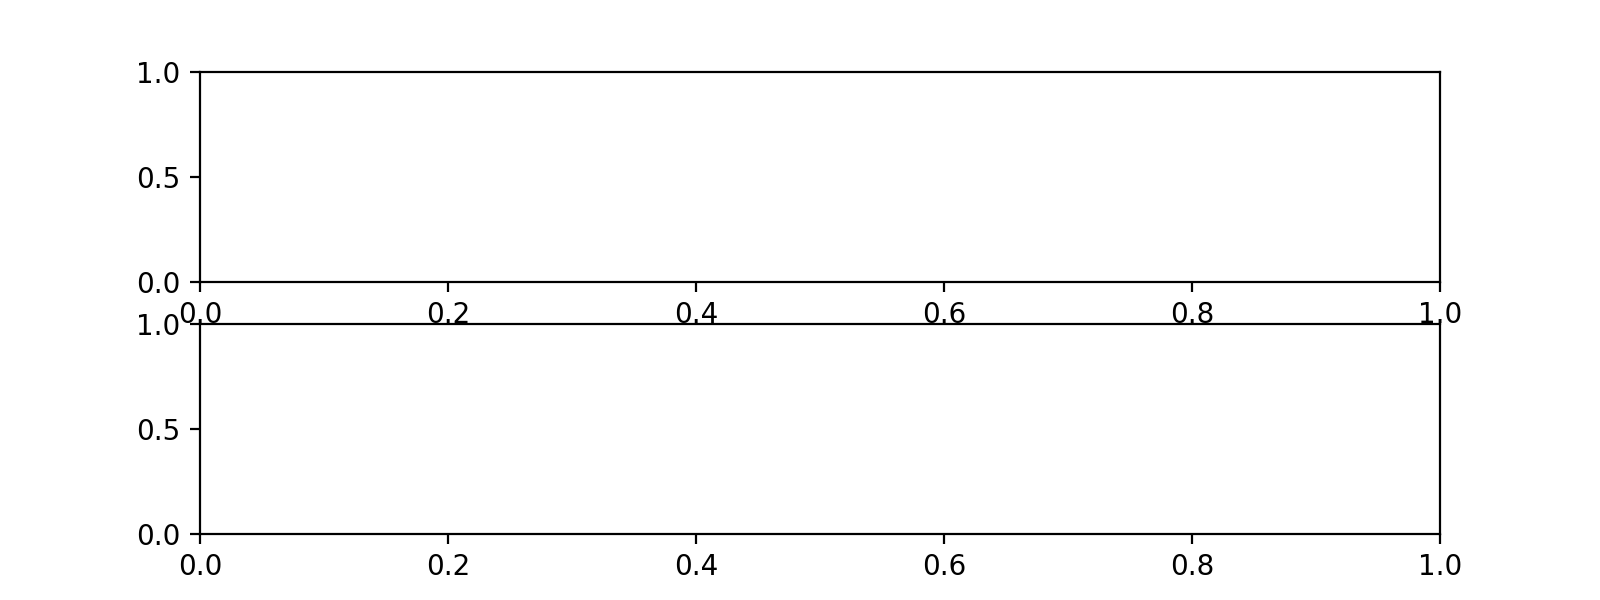

In [7]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib nbagg

p0 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p0:', layout=widgets.Layout(height='300px'), orientation='vertical')
p1 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p1:', layout=widgets.Layout(height='300px'), orientation='vertical')
p2 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p2:', layout=widgets.Layout(height='300px'), orientation='vertical')
p3 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p3:', layout=widgets.Layout(height='300px'), orientation='vertical')
p4 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p4:', layout=widgets.Layout(height='300px'), orientation='vertical')
p5 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p5:', layout=widgets.Layout(height='300px'), orientation='vertical')
p6 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p6:', layout=widgets.Layout(height='300px'), orientation='vertical')
p7 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p7:', layout=widgets.Layout(height='300px'), orientation='vertical')
p8 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p8:', layout=widgets.Layout(height='300px'), orientation='vertical')
p9 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p9:', layout=widgets.Layout(height='300px'), orientation='vertical')
p10 = widgets.IntSlider(min=-1e6, max=1e6, value=1e5, step=1e4, description='p10:', layout=widgets.Layout(height='300px'), orientation='vertical')

fig2, ax = plt.subplots(2, figsize=(8, 3))
    
def update_plot(p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10):
    p = [p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]
    balance = []
    ll = 1/(len(p)-1)
    for i in range(len(p)):
        if i == 0:
            balance.append(
               - p[i] *  (rho_times_k_eff(p[i]/2+p[i+1]/2)/ll)\
               + p[i+1] *rho_times_k_eff(p[i]/2+p[i+1]/2)/ll)
        elif i > 0 and i < len(p)-1:
            balance.append(
                 p[i-1] * rho_times_k_eff(p[i-1]/2+p[i]/2)/ll \
               - p[i] *  (rho_times_k_eff(p[i-1]/2+p[i]/2)/ll + rho_times_k_eff(p[i]/2+p[i+1]/2)/ll)\
               + p[i+1] *rho_times_k_eff(p[i]/2+p[i+1]/2)/ll)
        elif i == len(p)-1:
            balance.append(
                 p[i-1] * rho_times_k_eff(p[i-1]/2+p[i]/2)/ll \
               - p[i] *  (rho_times_k_eff(p[i-1]/2+p[i]/2)/ll))
    x = np.linspace(0, 1, len(balance))
    ax[0].clear()
    ax[0].plot(x, balance)
    ax[0].set_xlim(x[0], x[-1])
    #ax[0].set_ylim(-5e-5, 5e-5)
    ax[0].grid()
    ax[0].set_ylabel("$\\mathrm{div}_n ( \mathbf{A} ) \, / \, \\mathrm{kg} \, \\mathrm{s}^{-1}$")
    ax[1].clear()
    ax[1].plot(x, [pr/1e6 for pr in p], marker = 'x')
    ax[1].set_xlim(x[0], x[-1])
    ax[1].set_ylim(-1, 1)
    ax[1].grid()
    ax[1].set_xlabel('distance $x \, / \, m$') 
    ax[1].set_ylabel("pressure $p \, / \, \\mathrm{MPa}$")
    fig2.show()
    
widgets.interactive(update_plot, p0=p0, p1=p1, p2=p2, p3=p3, p4=p4, p5=p5, p6=p6, p7=p7, p8=p8, p9=p9, p10=p10)
# Arrange sliders in a horizontal box
hbox = widgets.HBox([p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10])
# Display the sliders
display(hbox)
fig2.show()


## Using matrix notation
Because computers can handle matrices as well as linear operations very well, it is convenient to write down the mass balance equations for all $N+1$ volumes using a matrix notation. The large matrix in the center contains all the hydraulic conductivity coefficients and has $(N+1)\times (N+1)$ columns and rows. The vector on the right side has $N+1$ rows contains the liquid pressures in all $N+1$ volumes. One can see that by carrying out the matrix multiplication, one arrives again at the equations given above. For shorter notation, we define $k_n^{\mathrm{right}} = k_\mathrm{eff} \bigl( \tilde{p}_n^{\,,\mathrm{right}}\bigr)$ and $\rho_n^{\mathrm{right}} = \rho \bigl( \tilde{p}_n^{\,,\mathrm{right}}\bigr)$ and an analogous notation for all coefficients involving average liquid pressures between cells.

\begin{equation}
\begin{bmatrix}
\rho_0^\mathrm{right} k_0^\mathrm{right}  l^{-1} & - \rho_0^\mathrm{right} k_0^\mathrm{right} l^{-1} & 0 & 0 & 0 & 0 & 0 \\
\vdots & \ddots & \ddots & 0 & 0 & 0 & \vdots \\
\vdots & 0 & - \rho_n^\mathrm{left} k_n^\mathrm{left} l^{-1} & \rho_n^\mathrm{left} \left(k_n^\mathrm{left} + \rho_n^\mathrm{right} k_n^\mathrm{right} \right)  l^{-1} & - \rho_n^\mathrm{right} k_n^\mathrm{right} l^{-1}& 0 & \vdots\\
\vdots & 0 & 0 & 0  & \ddots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & - \rho_N^\mathrm{left} k_N^\mathrm{left} l^{-1} & \rho_N^\mathrm{left} k_N^\mathrm{left}  l^{-1} \\
\end{bmatrix}\begin{bmatrix}
p_0\\
\vdots\\
p_n \\
\vdots \\
p_N \\
\end{bmatrix} = \begin{bmatrix}
0 \\
\vdots\\
0 \\
\vdots \\
0 \\
\end{bmatrix}
\end{equation}

One can see that we now have transformed the mass balance equation into a linear matrix multiplication, which takes the form $\mathbf{B} \mathbf{p} = \mathbf{0}$, where $\mathbf{B}$ represents the matrix containing all hydraulic conductivity coefficients and $\mathbf{p}$ is a vector containing all the pressures in each volume. $\mathbf{p}$ is actually also the solution we seek (i.e. the pressures in all volumes which satisfy the equation above). We call the vector $\mathbf{0}$ the right hand side (rhs) henceforth. Computers using numerical libraries (such as numpy) can calculate the solutions to such linear equation systems very fast.

In [8]:
def solve_linear_equation_system(p_vector):
    matrix = compute_matrix_coefficients(p_vector)  # create the matrix containing 
                                                    # all hydraulic coefficients
    rhs = np.zeros(len(p_vector))                   # create the "right hand side" vector
    matrix, rhs = apply_BCs(matrix, rhs)            # modify the matrix and rhs to
                                                    # apply the boundary conditions
    return np.linalg.solve(matrix, rhs)             # Numpy's function solving the
                                                    # defined linear equation system

The function defined above in turn calls some more functions that create the matrix $\mathbf{B}$ and the rhs vector. Let us write some code that creates the matrix $\mathbf{B}$, which is dependent on the liquid pressure in each volume. It uses the length of the input (our last best guess for the solution, i.e. the vector containing the liquid pressures in all volumes) in order to return the correct matrix dimensions:

In [9]:
def compute_matrix_coefficients(p_vector):
    matrix = np.zeros([len(p_vector), len(p_vector)]) # initialize a matrix of zeros with
                                                      # correct number of rows and columns    
    for i in range(len(p_vector)):
        if i == 0:  # Special treatment for the first volume (left boundary)
            p_right = (p_vector[i] + p_vector[i+1]) / 2  # average pressure on the right
            matrix[i, i]   = -rho_times_k_eff(p_right) / l         # central contribution
            matrix[i, i+1] = rho_times_k_eff(p_right) / l          # right contribution
            
        elif i == len(p_vector) - 1:  # Special treatment for the last volume (right boundary)
            p_left = (p_vector[i-1] + p_vector[i]) / 2  # average pressure on the left
            matrix[i, i-1] = rho_times_k_eff(p_left) / l           # left contribution
            matrix[i, i]   = -rho_times_k_eff(p_left) / l          # central contribution
            
        else:  # General case for interior volumes
            p_left = (p_vector[i-1] + p_vector[i]) / 2   # average pressure on the left
            p_right = (p_vector[i] + p_vector[i+1]) / 2  # average pressure on the right
            matrix[i, i-1] = rho_times_k_eff(p_left) / l           # left contribution
            matrix[i, i]   = -(rho_times_k_eff(p_left) + rho_times_k_eff(p_right)) / l  # central contribution
            matrix[i, i+1] = rho_times_k_eff(p_right) / l          # right contribution

    return matrix

## Boundary conditions

Note that the equation system $\mathbf{B} \mathbf{p} = \mathbf{0}$ as we have defined it here has an infinite amount of possible solutions (for example, any constant pressure across the entire domain would satisfy the mass balance equation). Therefore, the numerical linear solver would fail to find a unique solution (feel free to try it later on). To solve this problem, we need to impose more restrictions or conditions on the equation system.

Therefore, the function ```solve_linear_equation_system()``` calls ```apply_BCs()```, which as the name suggests is here to prescribe additional boundary conditions. In general there are a few different options of how the boundaries can be modelled. Here, we discuss two options:

### Prescribing flow across the boundaries (Neumann boundary conditions)

Let us take a look at the equations decribing the mass balance in the boundary volumes $n$ and $N$ again (cf. section "Assembling the equation system for all volumes"). By leaving out the flow on the left side from $V_0$ and right side of $V_N$, we essentially assume zero mass flow across the respective outer boundaries. Instead, we could also generalize and introduce a variable prescribing flow across each respective boundary (Neumann boundary condition). So, starting from the discretized mass balance equation for each volume, we would get $0 = \mathbf{A}_0^\mathrm{right} \cdot I_0^\mathrm{right} - a_\mathrm{left}$ for the left boundary volume as well as $0 = a_\mathrm{right} - \mathbf{A}_N^\mathrm{left} \cdot I_N^\mathrm{left}$ for the boundary volumes, where $a$ represents the (constant) total mass flow across the respective boundary. Note that $a>0$ prescribes a flow towards the right whereas $a<0$ prescribes a flow towards the left. Including $a$ in the mass balance equations for $V_0$ and $V_N$ above yields

\begin{equation}
0 = \begin{cases}
    \text{for Volume 0: }  - a_\mathrm{left} + \frac{\rho \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr) k_\mathrm{eff} \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr)}{l} \, p_0 - \frac{\rho \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr) k_\mathrm{eff} \bigl( \tilde{p}_0^{\,\mathrm{right}} \bigr)}{l} \, p_{1}\\
    \text{for Volume N: } - \frac{\rho \bigl( \tilde{p}_N^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_N^{\,\mathrm{left}} \bigr)}{l} \, p_{N-1} + \frac{\rho \bigl( \tilde{p}_N^{\,\mathrm{left}}\bigr) k_\mathrm{eff} \bigl( \tilde{p}_N^{\,\mathrm{left} }\bigr)}{l} \, p_N + a_\mathrm{right}\\
\end{cases}
\end{equation}

Because the mass flows across the boundaries $a_\mathrm{left}$ and $a_\mathrm{right}$ are independent of $p$, they are not coefficients of the large matrix below. Instead we move them over to the other side of the equation with inverted signs, to end up with:

\begin{equation}
\begin{bmatrix}
\rho_0^\mathrm{right} k_0^\mathrm{right}  l^{-1} & - \rho_0^\mathrm{right} k_0^\mathrm{right} l^{-1} & 0 & 0 & 0 & 0 & 0 \\
\vdots & \ddots & \ddots & 0 & 0 & 0 & \vdots \\
\vdots & 0 & - \rho_n^\mathrm{left} k_n^\mathrm{left} l^{-1} & \rho_n^\mathrm{left} \left(k_n^\mathrm{left} + \rho_n^\mathrm{right} k_n^\mathrm{right} \right)  l^{-1} & - \rho_n^\mathrm{right} k_n^\mathrm{right} l^{-1}& 0 & \vdots\\
\vdots & 0 & 0 & 0  & \ddots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & - \rho_N^\mathrm{left} k_N^\mathrm{left} l^{-1} & \rho_N^\mathrm{left} k_N^\mathrm{left}  l^{-1} \\
\end{bmatrix}\begin{bmatrix}
p_0\\
\vdots\\
p_n \\
\vdots \\
p_N \\
\end{bmatrix} = \begin{bmatrix}
a_\mathrm{left} \\
\vdots\\
0 \\
\vdots \\
-a_\mathrm{right} \\
\end{bmatrix}
\end{equation}


### Prescribing pressures at boundaries (Dirichlet boundary conditions)
Dirichlet BCs can be used in order to prescribe and fix the liquid pressure in certain volumes. Let us fix the pressures at the right and the left boundaries of our 1D domain. The volume at the left boundary corresponds to $p_0$, and the volume on the right boundary to $p_N$ respectively. We apply a Dirichlet BC with the following work flow:
- First, replace all coefficients in the zeroth and last rows of $\mathbf{B}$ by zeros.
- Second, replace the entry on the diagonal of the respective row by the integer $1$ each
- Third, replace the zeroth and last entry of the rhs vector by the value of the liquid pressure we want to prescribe at the respective boundary.

Let us assume as an example that we want to prescibe a liquid pressure of $-2 \, \text{MPa}$ and $1 \, \text{MPa}$ at the left and right boundaries, respectively. The equation system above would then be modified to look like:

\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 \\
\vdots & \ddots & \ddots & 0 & 0 & 0 & \vdots \\
\vdots & 0 & - \rho_n^\mathrm{left} k_n^\mathrm{left} l^{-1} & \rho_n^\mathrm{left} \left(k_n^\mathrm{left} + \rho_n^\mathrm{right} k_n^\mathrm{right} \right)  l^{-1} & - \rho_n^\mathrm{right} k_n^\mathrm{right} l^{-1}& 0 & \vdots\\
\vdots & 0 & 0 & 0  & \ddots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}\begin{bmatrix}
p_0\\
\vdots\\
p_n \\
\vdots \\
p_N \\
\end{bmatrix} = \begin{bmatrix}
-2 \times 10^6\\
\vdots\\
0 \\
\vdots \\
1 \times 10^6 \\
\end{bmatrix}
\end{equation}

*Question:*
- Explain why this forces the solution to meet the conditions $p_0 = -2 \times 10^6$ and $p_N = 1 \times 10^6$, i.e. perform quickly the matrix multiplication only for the zeroth and last rows.

## Some thoughs on defining a suitable set of boundary conditions
The equation system describing the steady state needs some boundary conditions that reduce the number of possible solutions from infinite to one. If we use too few BCs, the PDE is indefinite, if we apply to many BCs, there might not be a solution at all and the numerical solver diverges. 
* Why are the following examples poor choices for BCs?
    1. Neumann BC for drainage on one boundary and nothing else
    2. Neumann BCs at both model boundaries that do not drain/inject liquid at the same rates
    3. Dirichlet BCs at the two model boundaries and an additional Dirichlet BC in the center volume of the model
    
    
* Here are some better or standart BC choices for a one-dimensional bar
    1. Dirichlet BCs at both boundaries
    2. Dirichlet BC at the one boundary and Neumann BC at the other
    3. Source term within the domain, and one or two Dirichlet BCs at the boundaries.
    4. Applying "no" BC corresponds to zero flux across the respective boundary ("Neumann with zero flux).

In let us in the following part use a Dirichlet BCs at the left and right domain boundaries:

In [10]:
def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Left boundary: Set entire first row to 0, then set the diagonal element to 1
    matrix[0, :] = 0
    matrix[0, 0] = 1
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] = -2.0e6  # Left boundary value in MPa
    rhs[-1] = 1.0e6  # Right boundary value in MPa
    
    return matrix, rhs

## A look at the final equation system in matrix form
Let us now have a look at what the matrices look like when fully assembled. In order to keep the size of the matrix manageable, let us define a liquid pressure vector with only five entries. We will see below, that the resulting matrix has entries on the main diagonal as well as on the two diagonals left and right to the main diagonal. All other matrix entries are equal to zero. Matrices that contain mostly zeros are called 'sparse matrices'. In the first and last row of the matrix, which correspond to the mass balances in the first (leftmost) and last (rightmost) volume, only the main diagonal has an entry which is equal to 1. This is because we applied the Dirichlet type boundary conditions at the left and right domain boundaries. Likewise, the rhs vector contains only zeros except for the first and last entry, where it contains the Dirichlet BC values we prescribe for the left and right BC.

In [11]:
test_p = np.linspace(-1,1,5)

test_matrix = compute_matrix_coefficients(test_p) # compute the coefficient matrix
test_rhs = np.zeros(len(test_p))       # compute the rhs vector
test_matrix, test_rhs = apply_BCs(test_matrix, test_rhs)          # apply the BCs

print("Calculated coefficients matrix:")
print(np.round(test_matrix,12))
print("Calculated right hand side:")
print(np.round(test_rhs,12))

Calculated coefficients matrix:
[[ 1.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [-4.8e-11  9.6e-11 -4.8e-11  0.0e+00  0.0e+00]
 [ 0.0e+00 -4.8e-11  9.6e-11 -4.8e-11  0.0e+00]
 [ 0.0e+00  0.0e+00 -4.8e-11  9.6e-11 -4.8e-11]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00]]
Calculated right hand side:
[-2000000.        0.        0.        0.  1000000.]


## Intermediate summary

Now we have all pieces of Python code together to calculate the solution to the linearized mass balance equation. Let us recap what the code is doing until here.
* We have a function called ```solve_linear_equation_system()``` which calculates the solution (i.e. a vector containing the liquid pressures in each volume) to equation system linearised using the finite volume method. This function takes as an input a pressure vector, which serves two purposes:
    1. The length of the input vector tells our code the amount of finite volumes we are using for the discretization. The code uses this information create the coefficient matrix etc. with the correct dimensions.
    2. The input vector should be seen as our "current best guess" for the liquid pressure field. We will start by simply assuming that the pressure field corresponds to a constant gradient across the entire domain.
* ```solve_linear_equation_system()``` in turn calls the functions
    1. ```compute_matrix_coefficients()```, which creates the coefficient matrix by using linearized Darcy flow and the hydraulic condicivity definition given in the beginning of the script. It uses the previous best guess for the liquid pressures as a basis to calculate the hydraulic conductivity.
    2. ```compute_rhs_coefficients()```, wich creates the right hand side vector.
    3. ```apply_BCs()``` which modifies the beforehand created coefficient matrix and rhs by applying Dirichlet BCs to them.
    4. ```np.linalg.solve()```, which belongs to Numpy's numerical library and which solves a linear equation system of the form $\mathbf{B} \mathbf{p} = \mathbf{b}$, thus returning a new updated guess for the liquid pressure field. 
* Note here that the updated guess is calculated based on the hydraulic conductivities resulting from our previous guess (which might be far off the actual solution). Therefore, the updated guess is not necessarily correct but one can hope that it is a better guess than the previous one. We can use the updated guess iteratively for an improved estimation of the hydraulic conductivities and a repeated solution of the equation system. This type of iteration scheme is called the Picard or fixed point iteration.  

## Defining an inital guess for the pressure profile

Let us make an initial guess for the liquid pressure solution by assuming a simple constant liquid pressure gradient across the 1D domain. At the boundaries, we know that the pressure must be equal to the Dirichlet BCs:

In [12]:
solution = np.linspace(-2e6, 1e6, num_volumes)

## Some functions for creating plots and comparisons with reference solutions
In order to have something to compare against, we have some pre-fabricated data here. This is a steady state solution computed by OpenGeoSys-6 for the same 1D problem with the boundary conditions used in this example. Let us write a short function which creates a plot comparing our current best guess for the solution against the correct OpenGeoSys solution:

In [13]:
def compare_results(solution, OGS_ref_result):
    # Some data containing the reference solutions (OpenGeoSys-6)
    OGS_results = {"example_1" : 
                [-1.99999800e+06, -1.68206044e+06, -1.44793896e+06,
                 -1.26503545e+06, -1.11636303e+06, -9.92821771e+05,
                 -8.87023092e+05, -7.95024421e+05, -7.13537152e+05,
                 -6.42082182e+05, -5.78704886e+05, -5.19652683e+05,
                 -4.67466157e+05, -4.18991576e+05, -3.74631282e+05,
                 -3.33511178e+05, -2.95990503e+05, -2.59677486e+05,
                 -2.28173160e+05, -1.96668882e+05, -1.68487878e+05,
                 -1.42359644e+05, -1.16231411e+05, -9.35347189e+04,
                 -7.24242552e+04, -5.13137914e+04, -3.22060888e+04,
                 -1.68179617e+04, -1.42983453e+03,  1.39582926e+04,
                  2.83906009e+04,  4.20781939e+04,  5.57657868e+04,
                  6.94533798e+04,  8.31408640e+04,  9.68280360e+04,
                  1.10515249e+05,  1.24202421e+05,  1.37889593e+05,
                  1.51576591e+05,  1.65263291e+05,  1.78949991e+05,
                  1.92636691e+05,  2.06323391e+05,  2.20010091e+05,
                  2.33696362e+05,  2.47382575e+05,  2.61068747e+05,
                  2.74754919e+05,  2.88441091e+05,  3.02127263e+05,
                  3.15813200e+05,  3.29498820e+05,  3.43184439e+05,
                  3.56870059e+05,  3.70555679e+05,  3.84241298e+05,
                  3.97926822e+05,  4.11611932e+05,  4.25297041e+05,
                  4.38982151e+05,  4.52667260e+05,  4.66352370e+05,
                  4.80037200e+05,  4.93721868e+05,  5.07406535e+05,
                  5.21091203e+05,  5.34775871e+05,  5.48460254e+05,
                  5.62144538e+05,  5.75828823e+05,  5.89513190e+05,
                  6.03197328e+05,  6.16881280e+05,  6.30565231e+05,
                  6.44249183e+05,  6.57932946e+05,  6.71616608e+05,
                  6.85300270e+05,  6.98983852e+05,  7.12667262e+05,
                  7.26350671e+05,  7.40033997e+05,  7.53717186e+05,
                  7.67400376e+05,  7.81083412e+05,  7.94766410e+05,
                  8.08449319e+05,  8.22132149e+05,  8.35814901e+05,
                  8.49497584e+05,  8.63180251e+05,  8.76862782e+05,
                  8.90545224e+05,  9.04227582e+05,  9.17909869e+05,
                  9.31592081e+05,  9.45274218e+05,  9.58956278e+05,
                  9.72638261e+05,  9.86320168e+05,  1.00000200e+06],
                   "example_2" : 
                [-1999997.99999998, -1306486.15127898,  -936851.1782589 ,
                  -693999.17911915,  -517194.60932386,  -382128.9491422 ,
                  -273656.58038412,  -184731.66316256,  -110364.09856067,
                   -50093.52357568,    -3355.79895295,    38600.07333458,
                    77072.46983042,   115544.33804779,   154015.59178039,
                   192486.24605296,   230956.23440332,   269425.93419532,
                   307894.54288175,   346363.09367234,   384830.63491455,
                   423297.55256348,   461764.47021242,   500230.17694011,
                   538695.23928663,   577160.30163315,   615624.68420361,
                   654087.63890488,   692550.59360615,   731013.54830742,
                   769475.15726792,   807935.71770993,   846396.27815194,
                   884856.83859395,   923316.69658179,   961774.53723959,
                  1000232.49365685,  1038690.33431465,  1077148.17497244,
                  1115604.87758299,  1154059.62875698,  1192514.37993097,
                  1230969.13110496,  1269423.88227895,  1307878.63345293,
                  1346330.53330165,  1384781.89088696,  1423233.13273266,
                  1461684.37457837,  1500135.61642407,  1538586.85826977,
                  1552290.11058241,  1541245.43985167,  1530200.76912094,
                  1519156.0983902 ,  1508111.42765947,  1497066.75692873,
                  1486022.03191595,  1474977.07168271,  1463932.11144948,
                  1452887.15121624,  1441842.190983  ,  1430797.23074976,
                  1419752.10956208,  1408706.89450829,  1397661.6794545 ,
                  1386616.46440071,  1375571.24934692,  1364525.86793137,
                  1353480.42858612,  1342434.98924087,  1331389.48340129,
                  1320343.95759996,  1309298.32083631,  1298252.68407266,
                  1287207.04730901,  1276161.29759755,  1265115.48707   ,
                  1254069.67654246,  1243023.81766729,  1231977.85419703,
                  1220931.89072677,  1209885.87585529,  1198839.77776931,
                  1187793.67968332,  1176747.48689634,  1165701.27032608,
                  1154654.99887452,  1143608.67801878,  1132562.30891005,
                  1121515.89626641,  1110469.35532463,  1099422.84658923,
                  1088376.2820521 ,  1077329.66423924,  1066283.00127011,
                  1055236.29025715,  1044189.53122572,  1033142.721956  ,
                  1022095.86369012,  1011048.95656061,  1000002.        ]}
    
    
    pL_OGS = OGS_results[OGS_ref_result]
    reference_x_coordinate = np.linspace(0,1,len(pL_OGS))               
    plt.figure()
    plt.plot(reference_x_coordinate, pL_OGS, \
         linewidth = 3, \
         label = "reference solution")
    plt.plot(np.linspace(0,1,num_volumes),solution, \
         linewidth = 3, \
         color = "black",\
         linestyle = "dotted",\
         label = "our solution")
    plt.ylabel(r"liquid pressure $p \, / \, \mathrm{Pa}$")
    plt.xlabel(r"distance $x \, / \, \mathrm{m}$")
    plt.grid()
    plt.legend()
    
def plot_result_no_comparison(solution):
    plt.figure()
    plt.plot(np.linspace(0,1,num_volumes),solution, \
         linewidth = 3, \
         color = "black",\
         linestyle = "dotted",\
         label = "our solution")
    plt.ylabel(r"liquid pressure $p  \, / \, \mathrm{Pa}$")
    plt.xlabel(r"distance $x \, / \, \mathrm{m}$")
    plt.grid()
    plt.legend()

## Comparing our initial guess to the reference

<IPython.core.display.Javascript object>


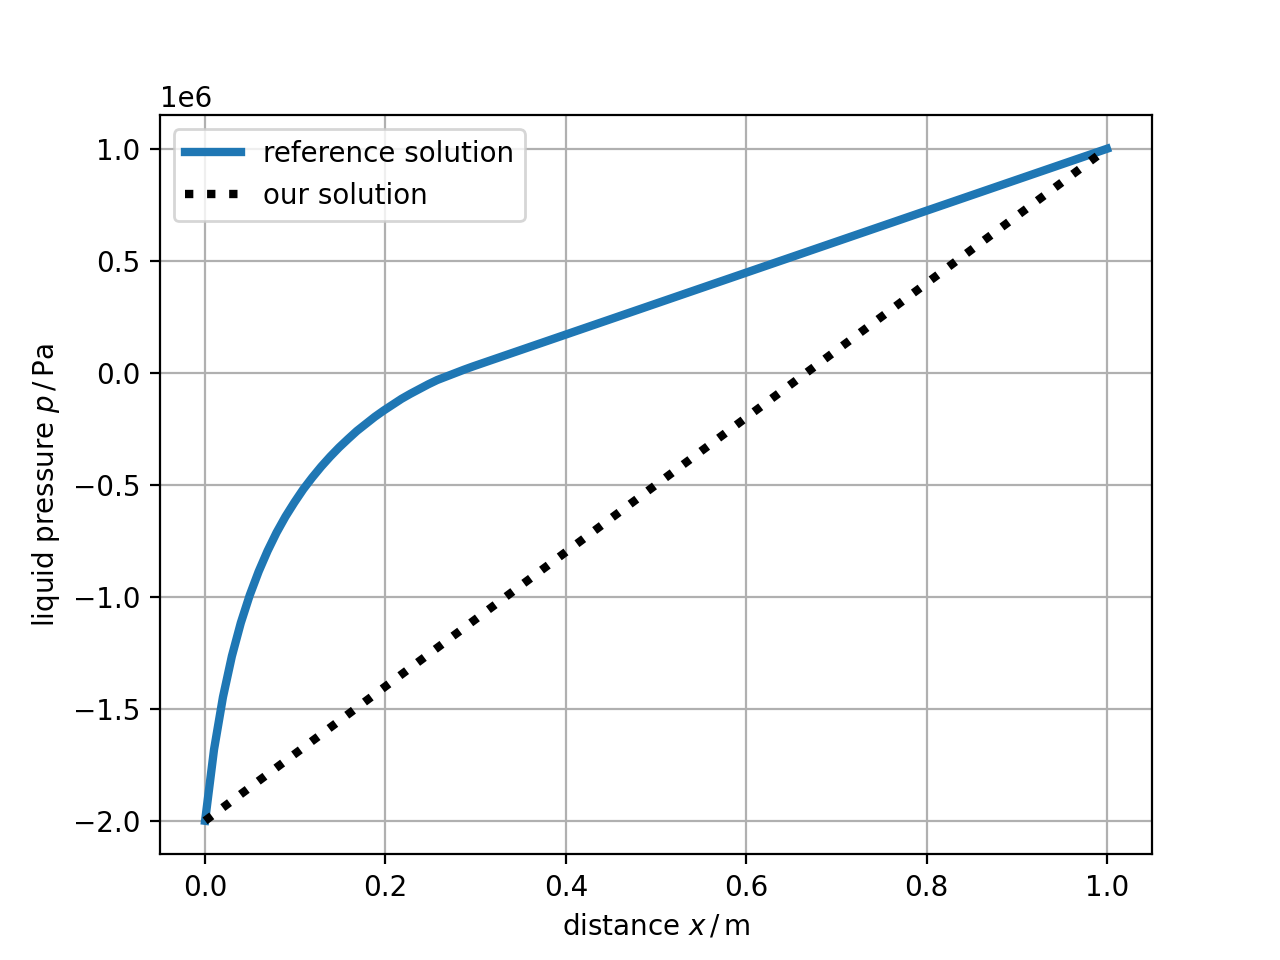

In [14]:
# Compare results from our current best guess with the OGS results:
compare_results(solution, "example_1")

We can see our initial guess for the liquid pressure field (the constant gradient) in the black, dotted line. It matches the reference at the boundaries (no surprise because of the BCs), but the guess is not so good for the rest of the domain. So far, we have not computed a solution to the linear equation system. 

## Solving the mass balance equation for the first time

So, let us proceed by calling ```solve_linear_equations(solution)```. Note that our code will overwrite the ```solution``` with the improved estimation:

<IPython.core.display.Javascript object>


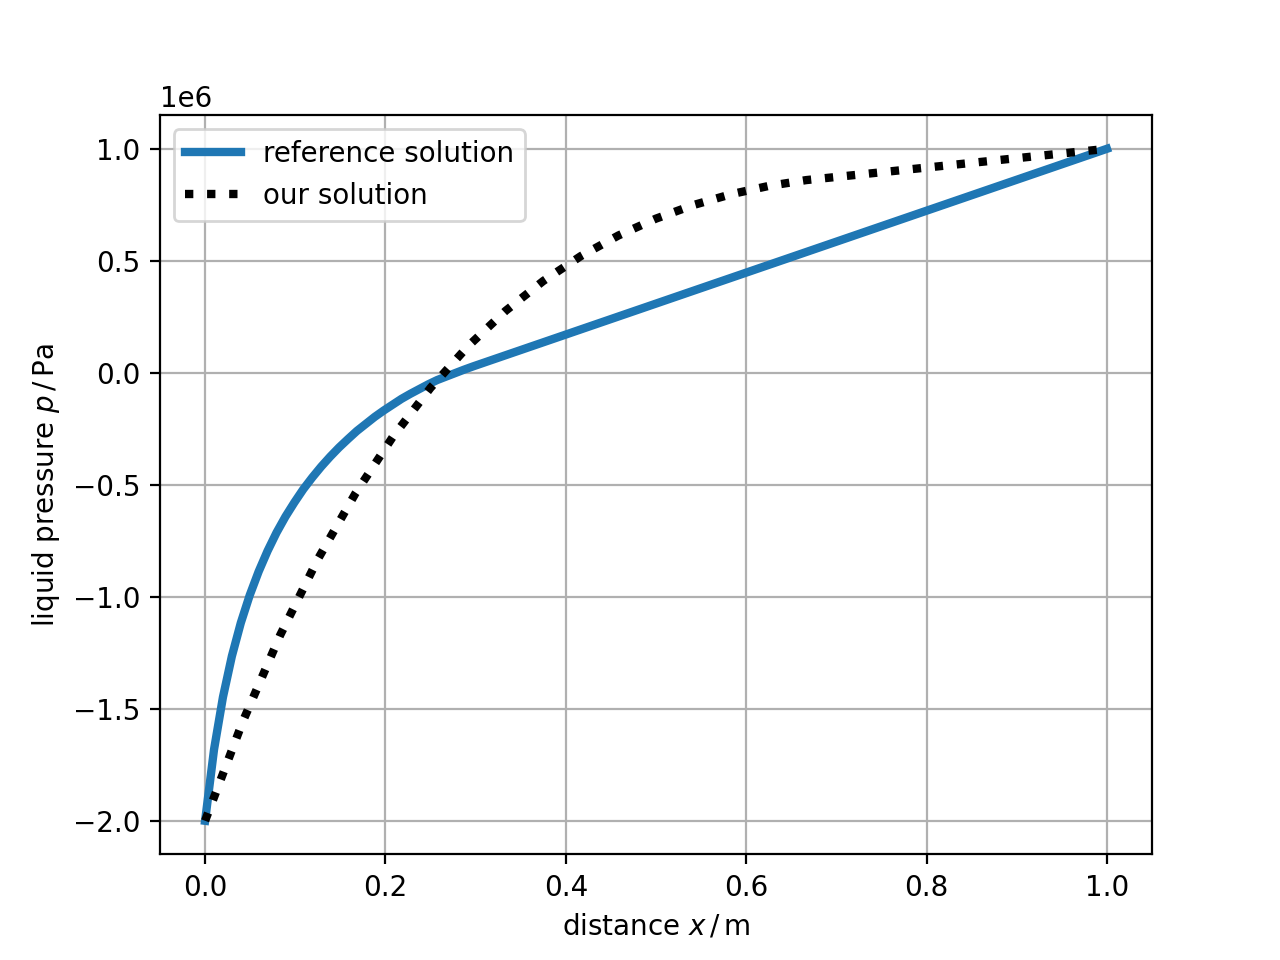

In [15]:
solution = solve_linear_equation_system(solution)
compare_results(solution, "example_1")

Near the boundaries, our initial guess was not too far of the actual solution. Therefore, we already calculated some good hydraulic conductivities here and one can see that the gradients near the boundaries already agree quite well after the first iteration. Still, there is room for improvement so we can repeat the solution process with the updated best guess. 

## Iterating the the solution of the linearised equation system (Picard)

We can repeatedly call the matrix assembly and solve the resulting linear equation system. We hope that each time, we improve our estimation of the hydraulic conductivities and therefore, each time, we get a better estimation of the liquid pressure profile. Because the hydraulic conductivity and liquid pressure depend on each other, the two mutually improve each other. This iteration scheme is called the Picard or fixed point iteration. For more interactive information, see https://mybinder.org/v2/gh/nagelt/Numerical_Methods_Introduction/HEAD?labpath=03_Generalized_Midpoint_Picard.ipynb

<img src="./figs/Iterating.png" alt="drawing" width="600"/>

Side note: It is not guaranteed that the fixed point iterations improve and converge all the time. Furthermore, iteration schemes like the Newton allow for a prediction of how non-linear factors such as the hydraulic conductivity change as a function of the liquid pressure. This information can be used to more effectively solve the equation system, usually resulting in a better convergence behaviour. For more information on the Newton scheme, see https://mybinder.org/v2/gh/nagelt/Numerical_Methods_Introduction/HEAD?labpath=04_Generalized_Midpoint_Newton.ipynb
In the following, we will stick to the Picard iteration because it is simpler to implement.

*Task:*
1. Manually perform the Picard iteration scheme by repeating the iterative solution of the balance equation. We will keep track of the number of iterations with this counter:

In [16]:
counter = 0

2. after how many repetitions (iterations) are we happy with the accuracy? I the cells below, click into the cell and pressing ```shift + enter```
3. What happens with our solution and the local mass balance when we repeat this with a coarser discretization? In the code cell in the section 'Approximating the divergence operator using finite volumes' of the script, we have set ```num_volumes``` equal to 100. We can change that value to, say, 10, and run the entire script until here.

Current iteration count is: 1


<IPython.core.display.Javascript object>


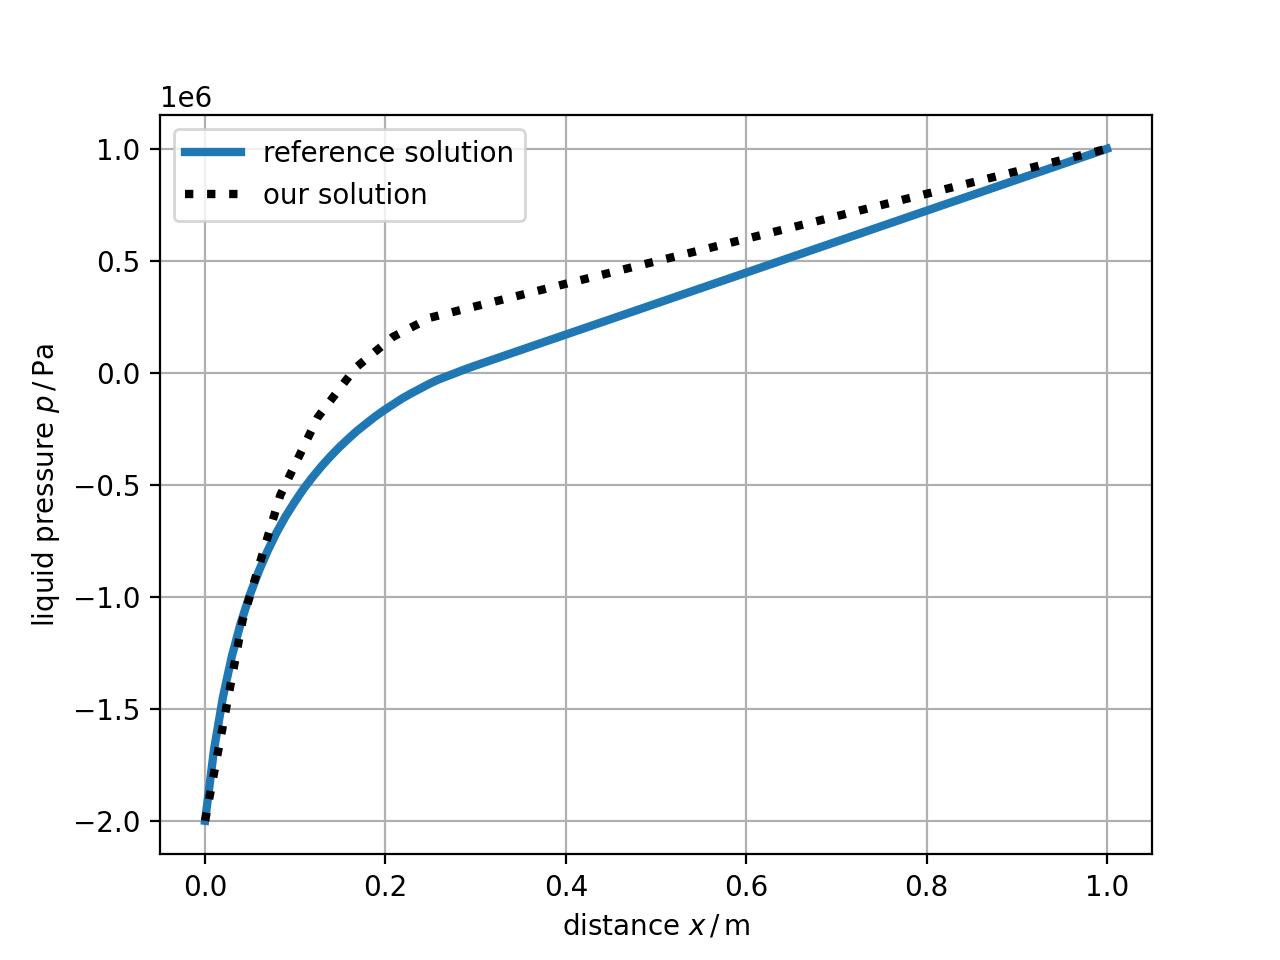

In [17]:
counter = counter + 1 # increment iteration count
solution = solve_linear_equation_system(solution) 
print("Current iteration count is:", counter)
compare_results(solution,"example_1")

## Automating the Picard (fixed point) iteration scheme
Actually, let us automate the Picard iteration process. Normally, we do not have a reference solution to compare against. Therefore, we need a criterion that tells us when to stop iterating (without knowing the correct solution). We can write a loop that automatically iterates a certain number of times until the difference between our last and current best guesses are small enough (convergence criterion). When using the automated iterations, we just have to define an initial guess from where the iteration can continue automatically. This automation follows this work flow:

1. We create a vector ```solution_last_iteration``` which can later be overwritten and updated after each iteration as well as an iteration counter.
2. We initialise a convergence criterion to be false, so that the code enters the while loop. Python will repeat the while loop as long as the convergence criterion is set to ```False```.
3. Inside the loop, we keep calculating new solutions based on the solution from the last respective iteration. If a maximum iteration count is exceeded, the code exits so as to not be stuck in an infinite loop in case the convergence criterion never reached. After calculating a new solution, we check the concergence (function described below) and we overwrite the ```solution_last_iteration``` with the new result.
4. After the convergence criterion is met, Pythone exits the ```while``` loop and makes a comparison plot.

In [18]:
def iterate_solution(initial_guess):
    max_iterations = 100
    solution_last_iteration = initial_guess
    iterations = 0
    convergence_crit = False
    while convergence_crit == False:
        if iterations > max_iterations:
            print('Max iterations exceeded.')
            print('Stopping iteration scheme.')
            break
        iterations = iterations + 1
        new_solution = solve_linear_equation_system(solution_last_iteration)
        convergence_crit = check_convergence(new_solution, solution_last_iteration)
        solution_last_iteration = new_solution
    print("Performed {} iterations in total".format(iterations))
    return new_solution

## Define a convergence criterion
The iteration scheme above checks the convergence criterion in every iteration after having computed each new solution. We proceed to define our criterion in terms of relative epsilon:
1. Calculate the norm of the difference of the old and new solutions ("how much has our result changed")
2. Calculate the norm of our current solution, so we can evaluate the change relative to the norm. Cautionary note: We'd have to escape the possibility of a zero norm in the denominator.
3. Print the norms and relative change for the user
4. Return ```True``` or ```False``` depending on whether or not the convergence criterion was met:

In [19]:
def check_convergence(new_solution, solution_last_iteration):
    dx = np.linalg.norm(new_solution-solution_last_iteration)
    x = np.linalg.norm(new_solution)
    relative_change = dx/x
    relative_epsilon = 1.0e-4
    print("convergence criterion"
          ": |dx|=",     np.format_float_scientific(dx, precision=3), \
          "; |x|=",      np.format_float_scientific(x, precision=3),\
          "; |dx|/|x|=", np.format_float_scientific(relative_change, precision=3))
    if relative_change <= relative_epsilon:
        return True
    else:
        return False

## Running the automated iterations
Now, let us see whether we can get some convergence here. Note, in the first line of the code below, we set the discretization back to 101 volumes just in case we played with the discretization before...

convergence criterion: |dx|= 9.039e+06 ; |x|= 8.635e+06 ; |dx|/|x|= 1.047e+00
convergence criterion: |dx|= 2.86e+06 ; |x|= 6.989e+06 ; |dx|/|x|= 4.091e-01
convergence criterion: |dx|= 2.252e+06 ; |x|= 6.080e+06 ; |dx|/|x|= 3.703e-01
convergence criterion: |dx|= 8.424e+05 ; |x|= 6.513e+06 ; |dx|/|x|= 1.293e-01
convergence criterion: |dx|= 8.410e+05 ; |x|= 6.673e+06 ; |dx|/|x|= 1.260e-01
convergence criterion: |dx|= 4.337e+05 ; |x|= 6.419e+06 ; |dx|/|x|= 6.757e-02
convergence criterion: |dx|= 3.825e+05 ; |x|= 6.329e+06 ; |dx|/|x|= 6.042e-02
convergence criterion: |dx|= 2.082e+05 ; |x|= 6.449e+06 ; |dx|/|x|= 3.228e-02
convergence criterion: |dx|= 1.842e+05 ; |x|= 6.475e+06 ; |dx|/|x|= 2.844e-02
convergence criterion: |dx|= 1.049e+05 ; |x|= 6.414e+06 ; |dx|/|x|= 1.636e-02
convergence criterion: |dx|= 8.394e+04 ; |x|= 6.403e+06 ; |dx|/|x|= 1.311e-02
convergence criterion: |dx|= 4.975e+04 ; |x|= 6.431e+06 ; |dx|/|x|= 7.735e-03
convergence criterion: |dx|= 3.866e+04 ; |x|= 6.435e+06 ; |dx|/|x

<IPython.core.display.Javascript object>


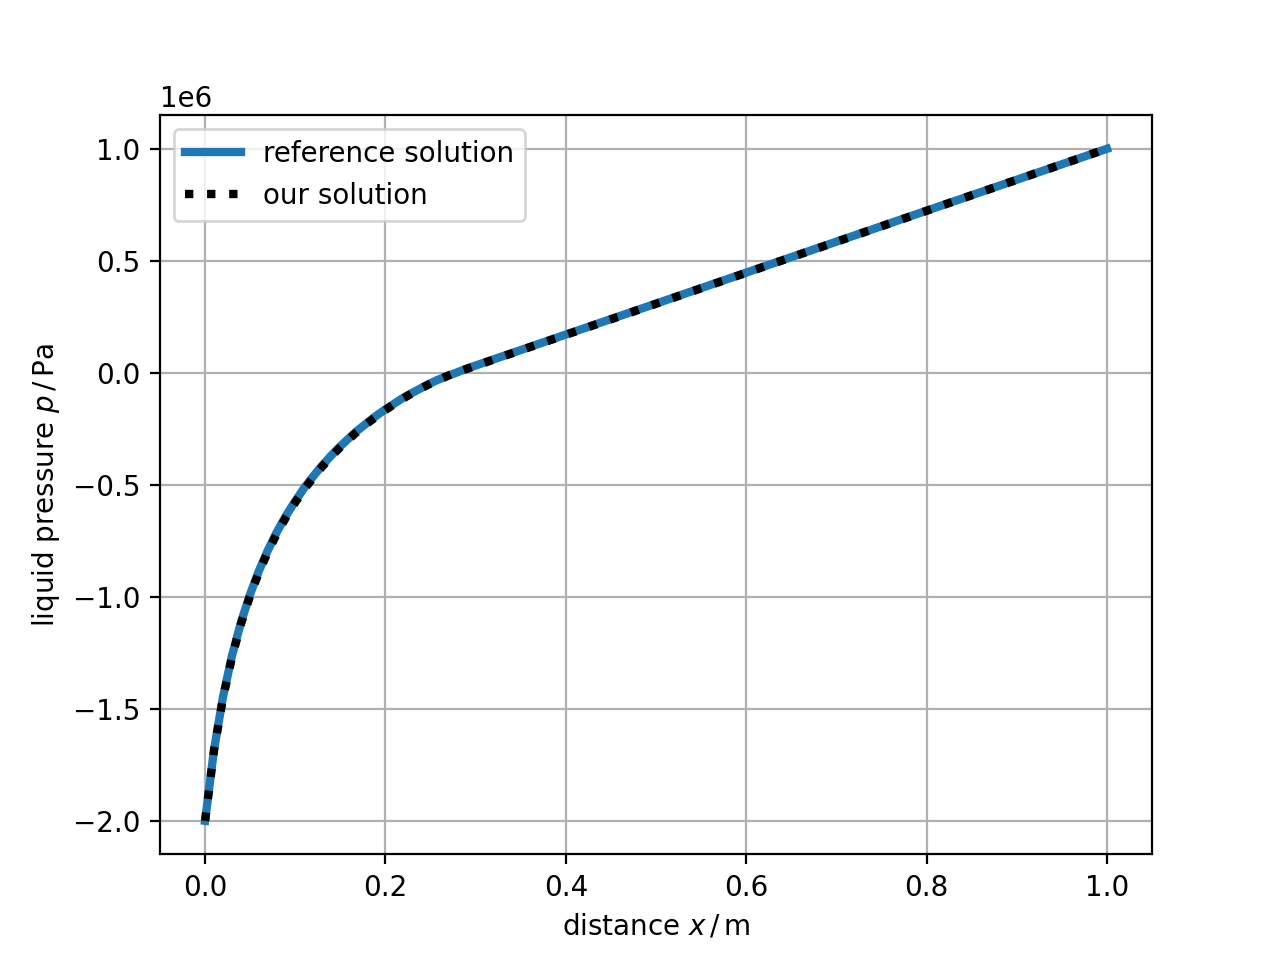

In [20]:
num_volumes = 101 # discretisation into N volumes
l = L/(num_volumes - 1) # distance between centres of two neighbouring volumes

initial_guess = np.linspace(-2e6, 1e6, num_volumes)
solution = iterate_solution(initial_guess)
compare_results(solution, "example_1")

*Questions:*
1. In the steady state, the mass flow $\mathbf{A}$ should be constant throughout the domain. How is the liquid pressure gradient then so non-linear? How could one demonstrate the reason?
2. Above we can see that in the fully liquid saturated part of the domain (where $p > 0$), the liquid pressure gradient is nearly constant, i.e. the liquid pressure distribution is nearly linear. Why is this? And why is it not perfectly constant?

### Testing how well our solution satisfies the mass balance equation

We can actually test how well our current best solution satisfies the equation

\begin{equation}
    0 = \mathrm{div}_n \left( \mathbf{A} \right)
\end{equation}

by writing a function that calculates the divergence based on the pore pressures from our solution and plots this result:

In [21]:
def analyse_mass_balance(solution):
    p = solution
    balance = []
    for i in range(len(p)):
        if i == 0:
            balance.append(
               - p[i] *  (rho_times_k_eff(p[i]/2+p[i+1]/2)/l)\
               + p[i+1] *rho_times_k_eff(p[i]/2+p[i+1]/2)/l)
        elif i > 0 and i < len(p)-1:
            balance.append(
                 p[i-1] * rho_times_k_eff(p[i-1]/2+p[i]/2)/l \
               - p[i] *  (rho_times_k_eff(p[i-1]/2+p[i]/2)/l + rho_times_k_eff(p[i]/2+p[i+1]/2)/l)\
               + p[i+1] *rho_times_k_eff(p[i]/2+p[i+1]/2)/l)
        elif i == len(p)-1:
            balance.append(
                 p[i-1] * rho_times_k_eff(p[i-1]/2+p[i]/2)/l \
               - p[i] *  (rho_times_k_eff(p[i-1]/2+p[i]/2)/l))
    plt.figure()
    plt.plot(np.linspace(0,1,len(balance)), balance)
    plt.ylabel(r"Local mass balance $\mathrm{div}_n \left( \mathbf{A} \right) \, / \, \mathrm{kg} \, \mathrm{m}^2 \, \mathrm{s}^{-1}$")
    plt.xlabel(r"distance $x \, / \, \mathrm{m}$")
    plt.grid()

Let us run the function above using our converged solution and discuss the mass balance the we see. Let us discuss the following equations using the plot of the local mass balance below:

*Questions:*
1. What does it mean for the mass balance plot to be nearly equal to zero for all points within the 1D domain?
2. What does it mean that at the boundaries, the mass balance is not equal to zero? Why is the mass balance on the left boundary equal and opposite to the mass balance at the right boundary? Argue using the principle of conservation of mass.
3. How does the mass balance change, if we run fewer iterations? This can be done by editing the function ```iterate_solution()``` defined above and setting  ```max_iterations = 2```, for example.

convergence criterion: |dx|= 9.039e+06 ; |x|= 8.635e+06 ; |dx|/|x|= 1.047e+00
convergence criterion: |dx|= 2.86e+06 ; |x|= 6.989e+06 ; |dx|/|x|= 4.091e-01
convergence criterion: |dx|= 2.252e+06 ; |x|= 6.080e+06 ; |dx|/|x|= 3.703e-01
convergence criterion: |dx|= 8.424e+05 ; |x|= 6.513e+06 ; |dx|/|x|= 1.293e-01
convergence criterion: |dx|= 8.410e+05 ; |x|= 6.673e+06 ; |dx|/|x|= 1.260e-01
convergence criterion: |dx|= 4.337e+05 ; |x|= 6.419e+06 ; |dx|/|x|= 6.757e-02
convergence criterion: |dx|= 3.825e+05 ; |x|= 6.329e+06 ; |dx|/|x|= 6.042e-02
convergence criterion: |dx|= 2.082e+05 ; |x|= 6.449e+06 ; |dx|/|x|= 3.228e-02
convergence criterion: |dx|= 1.842e+05 ; |x|= 6.475e+06 ; |dx|/|x|= 2.844e-02
convergence criterion: |dx|= 1.049e+05 ; |x|= 6.414e+06 ; |dx|/|x|= 1.636e-02
convergence criterion: |dx|= 8.394e+04 ; |x|= 6.403e+06 ; |dx|/|x|= 1.311e-02
convergence criterion: |dx|= 4.975e+04 ; |x|= 6.431e+06 ; |dx|/|x|= 7.735e-03
convergence criterion: |dx|= 3.866e+04 ; |x|= 6.435e+06 ; |dx|/|x

<IPython.core.display.Javascript object>


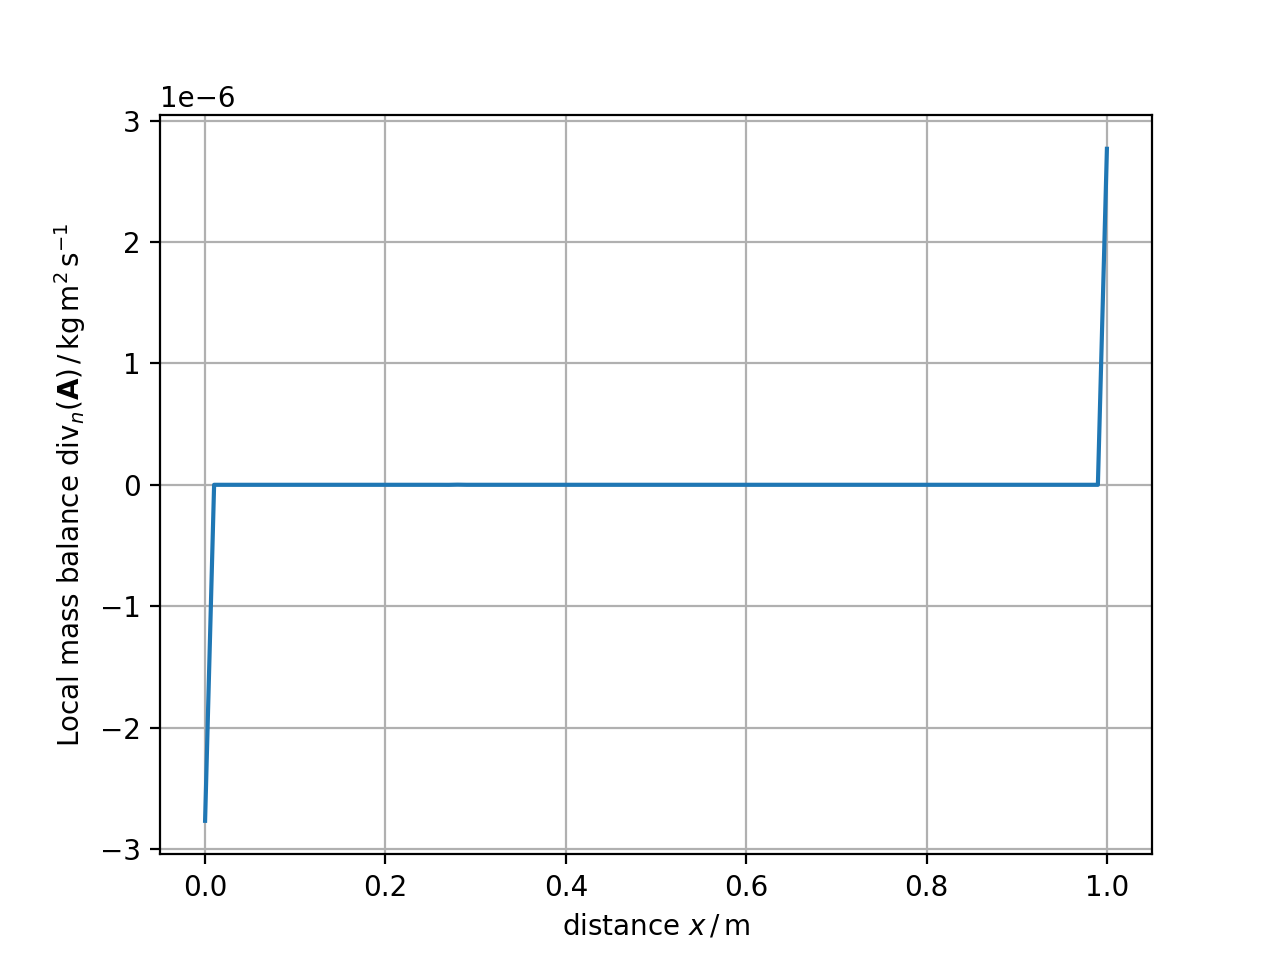

In [22]:
solution = iterate_solution(initial_guess)
analyse_mass_balance(solution)

## Trying out Neumann BCs

In the mass balance plot above, we can see that at the left boundary, water is drained from the model at a rate of $-2.767386338726807 \times 10^{-6} \, \mathrm{kg} \, \mathrm{s}^{-1}$. Let us try to get the same result by directly applying this drainage rate as a neumann BC by adjusting the ```apply_BCs()``` function. Note that we want to model drainage at the left side, therefore the mass flow at the boundary needs to be towards the left, hence $a_\mathrm{left}$ has a negative sign. If we wanted to model drainage at the right boundary, we would have to assign a positive value in the rhs vector according to the equations in the section about the Neumann BC. Let us do the manual iteration once more by repeatedly running the cell below. We can see how the solution converges, but does so in a different way compared to the simulation with Dirichlet BCs at both boundaries.

In [30]:
# reset initial guess and iteration counter
# for the next example
solution = np.linspace(1e6, 1e6, num_volumes)
counter = 0 

Current iteration count is: 9


<IPython.core.display.Javascript object>


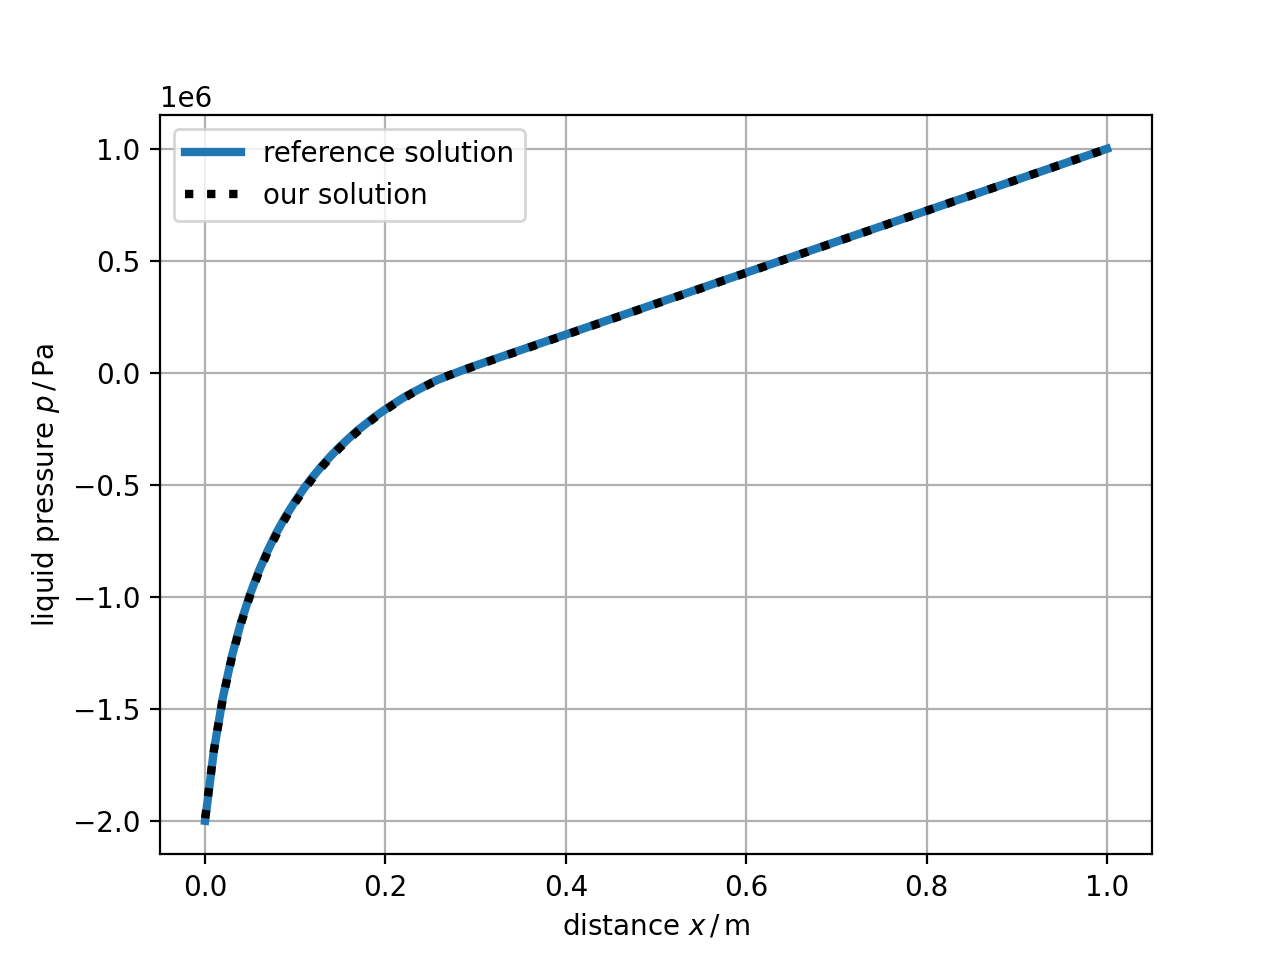

In [39]:
def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] = - 2.767386338726807e-06  # Left flow rate value in MPa
    rhs[-1] = 1.0e6  # Right boundary value in MPa
    
    return matrix, rhs

counter = counter + 1 # increment iteration count
solution = solve_linear_equation_system(solution) 
print("Current iteration count is:", counter)
compare_results(solution,"example_1")

## Variation 1: Exploring the impact of the relative permability on the solution

To further explore the second question, assume for a moment that the relative permeability is constant with $k_\mathrm{rel}=1$. We can do this by simply defining a new ```k_rel``` function, which will overwrite the previous definition. We then run our iteration scheme:

convergence criterion: |dx|= 3.288e+03 ; |x|= 1.012e+07 ; |dx|/|x|= 3.248e-04
convergence criterion: |dx|= 2.487e-01 ; |x|= 1.012e+07 ; |dx|/|x|= 2.457e-08
Performed 2 iterations in total


<IPython.core.display.Javascript object>


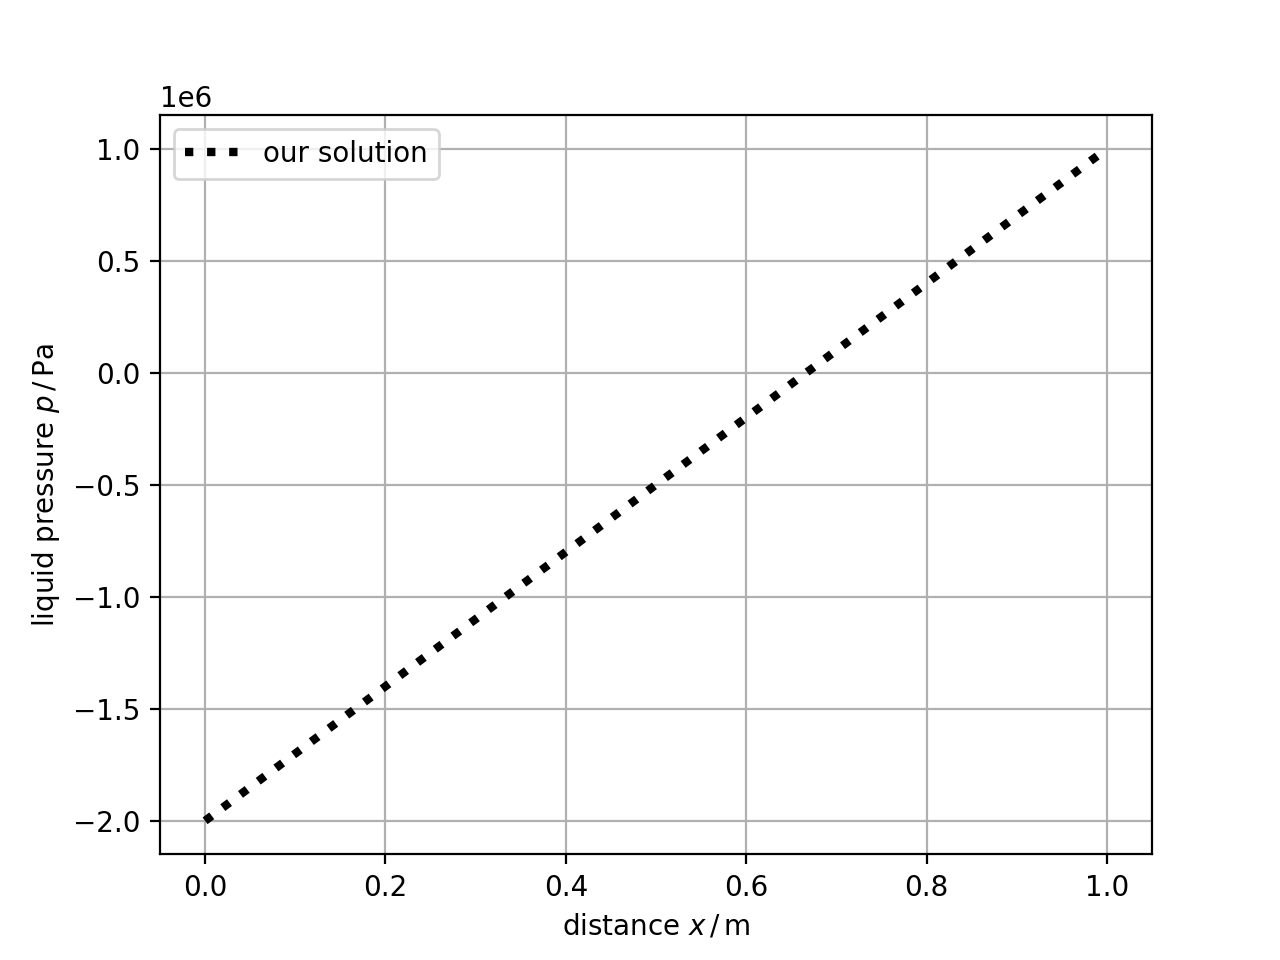

In [25]:
def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Left boundary: Set entire first row to 0, then set the diagonal element to 1
    matrix[0, :] = 0
    matrix[0, 0] = 1
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] = -2.0e6  # Left boundary value in MPa
    rhs[-1] = 1.0e6  # Right boundary value in MPa
    
    return matrix, rhs

def k_rel(p):
    return 1.0

initial_guess = np.linspace(-2e6, 1e6, num_volumes)
solution = iterate_solution(initial_guess)
plot_result_no_comparison(solution)

One can see that the converged result looks pretty linear. This is why the Picard scheme needed only two iterations to find a good solution. The linearity arises from the fact that we model the fluid flow using the Darcy law which inherently assumes that the fluid flow is linearly dependent on the fluid pressure gradient. By setting the relative permeability to a constant, we have eliminated the only major source of non-linearity in the mass balance equation. However, also the liquid density is not constant. But liquid is so incompressible that this non-linearity is invisible for our modeling purposes here. This can however be changed...

## Variation 2: Exploring the impact of the fluid density (modeling gas flow)
Now let us assume that the compressibility of the liquid is as high as that of air while keeping the relative permeability constant like above. If we actually were to model air flow, we should use the ideal gas law (feel free to implement it below), but the point can be made by just observing that air at room temperature and atmospheric pressure is about 20000 times higher than that of water and sticking to the linear density-pressure relation. Additionally, to model gas flow, we must change our Dirichlet boundary conditions to some positive values (let us choose $p_\mathrm{L} = 1.0 \, \text{MPa}$ at the left boundary and $p_\mathrm{L} = 2.0 \, \text{MPa}$ at the right boundary in order to have sensible results for gas flow. Let us simply overwrite the ```apply_BCs()``` function for that.

convergence criterion: |dx|= 4.615e+06 ; |x|= 2.477e+07 ; |dx|/|x|= 1.863e-01
convergence criterion: |dx|= 1.476e+06 ; |x|= 2.350e+07 ; |dx|/|x|= 6.28e-02
convergence criterion: |dx|= 2.409e+05 ; |x|= 2.347e+07 ; |dx|/|x|= 1.026e-02
convergence criterion: |dx|= 2.449e+05 ; |x|= 2.366e+07 ; |dx|/|x|= 1.035e-02
convergence criterion: |dx|= 7.848e+04 ; |x|= 2.359e+07 ; |dx|/|x|= 3.326e-03
convergence criterion: |dx|= 1.734e+04 ; |x|= 2.359e+07 ; |dx|/|x|= 7.352e-04
convergence criterion: |dx|= 1.536e+04 ; |x|= 2.360e+07 ; |dx|/|x|= 6.508e-04
convergence criterion: |dx|= 4.033e+03 ; |x|= 2.36e+07 ; |dx|/|x|= 1.709e-04
convergence criterion: |dx|= 1.337e+03 ; |x|= 2.36e+07 ; |dx|/|x|= 5.666e-05
Performed 9 iterations in total


<IPython.core.display.Javascript object>


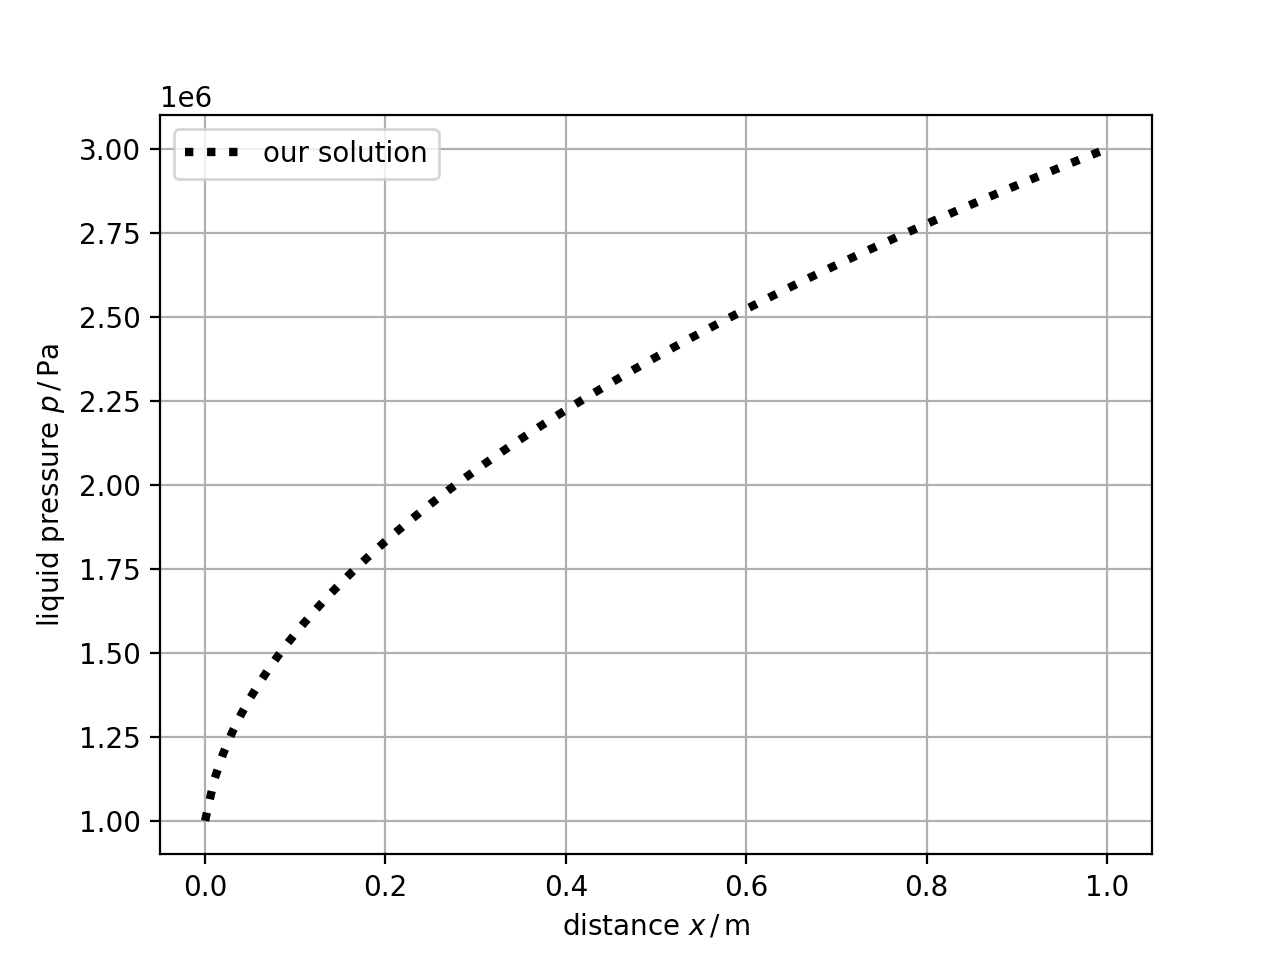

In [26]:
def rho(p):
    p_ref = 1.0e06   # reference liquid pressure / Pa
    beta_p = 8.0e-6 # liquid compressibility / Pa^-1
    rho_ref = 1000.0 # reference liquid density / kg m^-3
    return rho_ref * (1+beta_p*(p-p_ref))

def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Left boundary: Set entire first row to 0, then set the diagonal element to 1
    matrix[0, :] = 0
    matrix[0, 0] = 1
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] = 1.0e6   # Left boundary value in MPa
    rhs[-1] = 3.0e6  # Right boundary value in MPa
    
    return matrix, rhs


initial_guess = np.linspace(1.0e6, 3e6, num_volumes)
solution = iterate_solution(initial_guess)
plot_result_no_comparison(solution)

*Questions:*
* Why does increasing the fluid compressibility lead to such non-linear results?
* What are we implicitely assuming when modelling a constant relative permeability for gas?

## Variation 3: Source and sink terms:

For the last part of this script considering steady-state solutions, we want to consider source-terms. We want to return to modelling ground water flow, so we start by re-setting the liquid density and liquid relative permeability functions:

In [27]:
def k_rel(p):
    m = 1-1/n
    return np.sqrt(S(p)) * np.power(1-(np.power(1-np.power(S(p),1/m),m)),2)

def rho(p):
    p_ref = 1.0e06   # reference liquid pressure / Pa
    beta_p = 4.0e-10 # liquid compressibility / Pa^-1
    rho_ref = 1000.0 # reference liquid density / kg m^-3
    return rho_ref * (1+beta_p*(p-p_ref))

Next, we reconsider the linearized mass balance equation. We recall that in all volumes without sinks or sources, the liquid mass must be conserved.

\begin{equation}
     0= \mathrm{div}_n \, \left( \mathbf{A} \right)
\end{equation}

However, the equation above is not equal to zero if there is a sink. Let us assume that in the center of the domain at $x=50\,\mathrm{cm}$, there is a mass source of $\hat{Q}_\mathrm{volumetric} = 1.0 \times 10^{-6} \, \mathrm{kg}\,\mathrm{m}^{-3}\mathrm{s}^{-1}$. Since the finite volume that represents the source acts over a volume of $1\mathrm{m}^2 \cdot l$, we must scale the volumetric source by this value in order to compute the correct total source with units $\mathrm{kg}\,\mathrm{s}^{-1}$

\begin{equation}
    \hat{Q}_\mathrm{total} = \hat{Q}_\mathrm{volumetric} \cdot 1\mathrm{m}^2 \cdot l
\end{equation}

Now, the mass balance equation above can be modified *only for the volume containing the source*. In this volume, the mass balance is not equal to zero, but equal to the source so that

\begin{equation}
     \hat{Q}_\mathrm{total} = \mathrm{div}_n \, \left( \mathbf{A} \right)
\end{equation}

The convention of signs can be checked by considering that a positive source must lead to a positive value divergence, which we defined above to correspond to flow out of the volume. A negative source, i.e. a sink, leads to general flow towards the volume (negative divergence), which sounds plausible. Recalling the linearization scheme above, one can see that the source in (which is independent of the liquid pressure) ends up not as coefficient of the matrix $\mathbf{B}$ but rather as coefficient of the rhs vector. In this example, the source is present in volume $n$:

\begin{equation}
\hat{Q}_\mathrm{total} = \begin{cases}
    \text{for Volume n: } - k_\mathrm{eff}^{n,\mathrm{left}} l^{-1} \, p_{n-1} + \left(k_\mathrm{eff}^{n,\mathrm{left}} + k_\mathrm{eff}^{n,\mathrm{right}} \right)  l^{-1} \, p_n - k_\mathrm{eff}^{n,\mathrm{right}} l^{-1} \, p_{n+1}\\
\end{cases}
\end{equation}

Thus we can see that the matrix coefficients can remain unchanged when we want to implement a source term. We only need to include the source in the rhs assembly (note that we also change the Dirichlet BCs back to their respective original values):

In [28]:
def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Left boundary: Set entire first row to 0, then set the diagonal element to 1
    matrix[0, :] = 0
    matrix[0, 0] = 1
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] = -2.0e6   # Left boundary value in MPa
    rhs[-1] = 1.0e6  # Right boundary value in MPa
    
    # Apply mass source term to the volume in the centre of the domain
    rhs[int(len(rhs)/2)] = 1.0e-05 # total mass source in kg/s (Volumetric source: Q_vol = Q_total/l/1m2) 
    return matrix, rhs

convergence criterion: |dx|= 2.876e+07 ; |x|= 2.420e+07 ; |dx|/|x|= 1.188e+00
convergence criterion: |dx|= 1.121e+07 ; |x|= 1.411e+07 ; |dx|/|x|= 7.946e-01
convergence criterion: |dx|= 6.487e+06 ; |x|= 9.915e+06 ; |dx|/|x|= 6.542e-01
convergence criterion: |dx|= 4.119e+06 ; |x|= 1.272e+07 ; |dx|/|x|= 3.237e-01
convergence criterion: |dx|= 1.236e+06 ; |x|= 1.196e+07 ; |dx|/|x|= 1.034e-01
convergence criterion: |dx|= 2.26e+06 ; |x|= 1.054e+07 ; |dx|/|x|= 2.145e-01
convergence criterion: |dx|= 1.406e+06 ; |x|= 1.149e+07 ; |dx|/|x|= 1.224e-01
convergence criterion: |dx|= 4.013e+05 ; |x|= 1.150e+07 ; |dx|/|x|= 3.488e-02
convergence criterion: |dx|= 9.469e+05 ; |x|= 1.089e+07 ; |dx|/|x|= 8.695e-02
convergence criterion: |dx|= 3.898e+05 ; |x|= 1.115e+07 ; |dx|/|x|= 3.495e-02
convergence criterion: |dx|= 2.425e+05 ; |x|= 1.127e+07 ; |dx|/|x|= 2.151e-02
convergence criterion: |dx|= 3.365e+05 ; |x|= 1.105e+07 ; |dx|/|x|= 3.045e-02
convergence criterion: |dx|= 7.738e+04 ; |x|= 1.11e+07 ; |dx|/|x|

<IPython.core.display.Javascript object>


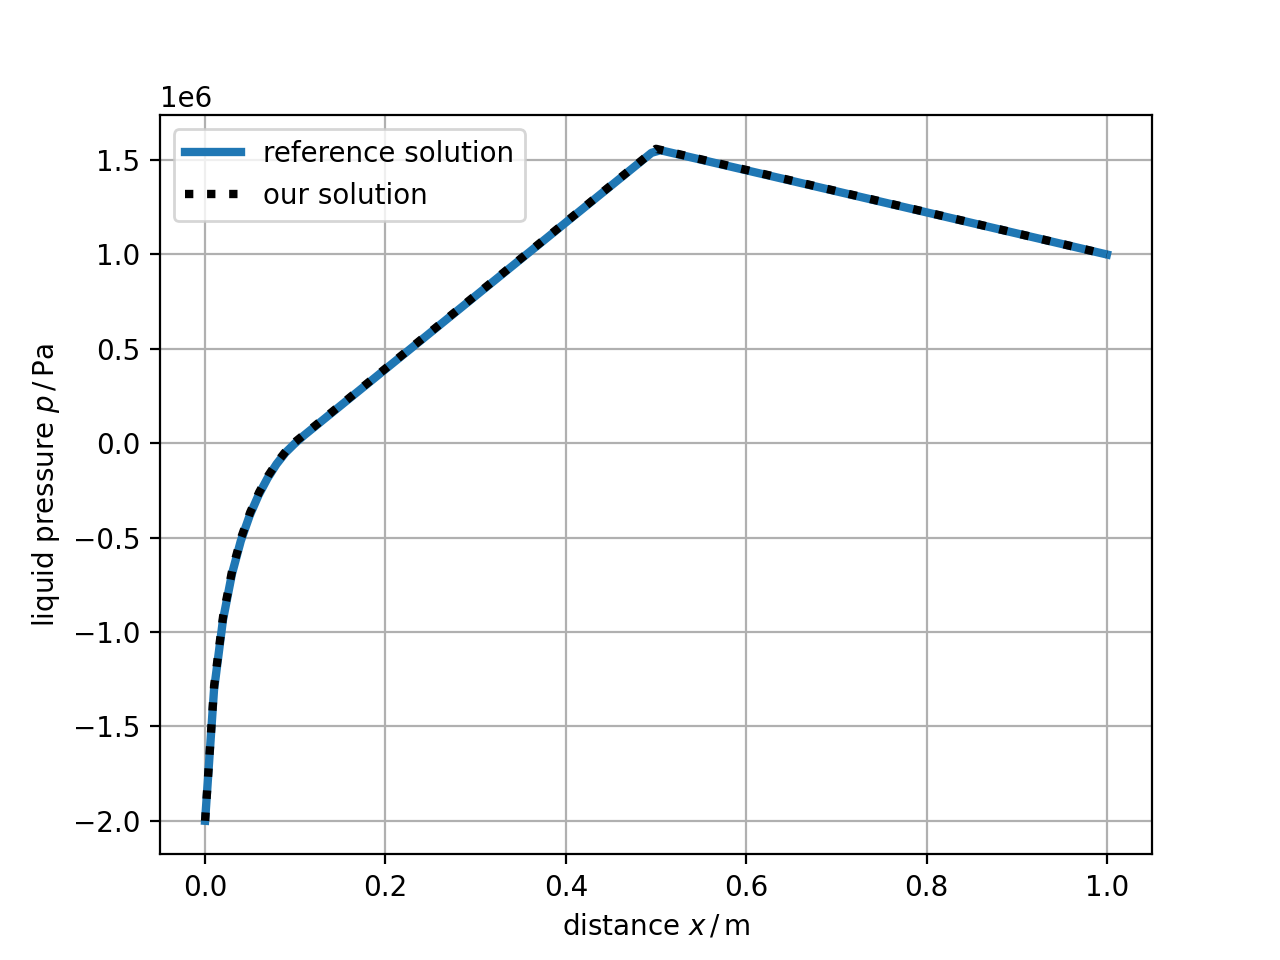

<IPython.core.display.Javascript object>


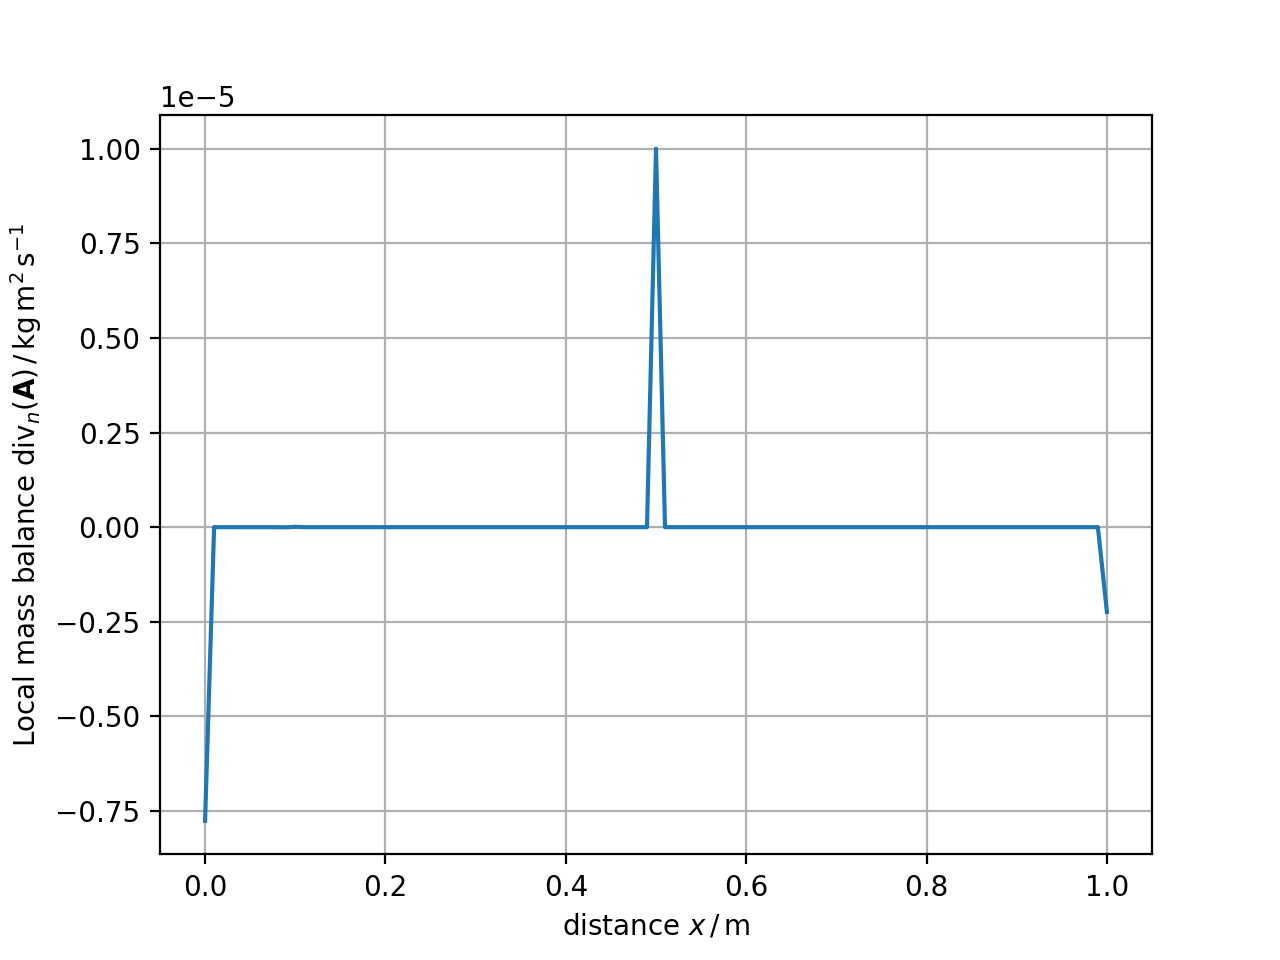

In [29]:
initial_guess = np.linspace(-2e6, 1e6, num_volumes)
solution = iterate_solution(initial_guess)
compare_results(solution, "example_2")
analyse_mass_balance(solution)

*Questions:*
* What is the interpretation of the steady state pressure profile we calculate for this case with a source?
* What happens to the pressure profile when the source is increased or decreased?
* The peak in the mass balance plot as a value of about $1.0 \times 10^{-5}$. Does that match our source? Why?
* At the left and right boundaries, the mass balance plot now has negative values. How do they relate to the mass source?
* How would we simulate a sink? Try it out a few values!

## Thank you for your attention!